# Tracking Failure Origins

The question of "Where does this value come from?" is fundamental for debugging. Which earlier variables could possibly have influenced the current erroneous state? And how did their values come to be?

When programmers read code during debugging, they scan it for potential _origins_ of given values. This can be a tedious experience, notably if the origins is spread across multiple separate locations, possibly even in different modules. In this chapter, we thus investigate means to _determine such origins_ automatically – by collecting data and control dependencies during program execution.

In [1]:
from bookutils import YouTubeVideo
# YouTubeVideo("w4u5gCgPlmg")

**Prerequisites**

* You should have read the [Introduction to Debugging](Intro_Debugging).
* To understand how to compute dependencies automatically (the second half of this chapter), you will need
    * advanced knowledge of Python semantics
    * knowledge on how to instrument and transform code
    * knowledge on how an interpreter works

In [2]:
import bookutils

In [3]:
from bookutils import quiz, next_inputs, print_content

## Synopsis
<!-- Automatically generated. Do not edit. -->

To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from debuggingbook.Slicer import <identifier>
```

and then make use of the following features.


This chapter provides a `Slicer` class to automatically determine and visualize dynamic dependencies. When we say that a variable $x$ depends on a variable $y$ (written $x \leftarrow y$), we distinguish two kinds of dependencies:

* **data dependencies**: $x$ obtains its value from a computation involving the value of $y$.
* **control dependencies**: $x$ obtains its value because of a computation involving the value of $y$.

Such dependencies are crucial for debugging, as they allow to determine the origins of individual values (and notably incorrect values).

To determine dynamic dependencies in a function `func` and its callees `func1`, `func2`, etc., use

```python
with Slicer(func, func1, func2) as slicer:
    <Some code involving func()>
```

and then `slicer.graph()` or `slicer.code()` to examine dependencies.

Here is an example. The `demo()` function computes some number from `x`:

```python
>>> def demo(x):
>>>     z = x
>>>     while x <= z <= 64:
>>>         z *= 2
>>>     return z
```
By using `with Slicer(demo)`, we first instrument `demo()` and then execute it:

```python
>>> with Slicer(demo) as slicer:
>>>     demo(10)
```
After execution is complete, you can use `slider.graph()` to visualize the dependencies as graph. Data dependencies are shown as black solid edges; control dependencies are shown as grey dashed edges. We see how the parameter `x` flows into `z`, which is returned after some computation that is control dependent on a `<test>` involving `z`.

```python
>>> slicer.graph()
```
![](PICS/Slicer-synopsis-1.svg)
An alternate representation is `slicer.code()`, annotating the instrumented source code with (backward) dependencies. Data dependencies are shown with `<=`, control dependencies with `<-`; locations (lines) are shown in parentheses.

```python
>>> slicer.code()
*    1 def demo(x):
*    2     z = x  # <= x (1)
*    3     while x <= z <= 64:  # <= x (1), z (4), z (2)
*    4         z *= 2  # <= z (4), z (2); <- <test> (3)
*    5     return z  # <= z (4)
```
Dependencies can also be retrieved programmatically. The `dependencies()` method returns a `Dependencies` object encapsulating the dependency graph.

The method `all_vars()` returns all variables in the dependency graph. Each variable is encoded as a pair (_name_, _location_) where _location_ is a pair (_codename_, _lineno_).

```python
>>> slicer.dependencies().all_vars()
{('<demo() return value>', ('demo', 5)),
 ('<test>', ('demo', 3)),
 ('x', ('demo', 1)),
 ('z', ('demo', 2)),
 ('z', ('demo', 4))}
```
`code()` and `graph()` methods can also be applied on dependencies. The method `backward_slice(var)` returns a backward slice for the given variable. To retrieve where `z` in Line 2 came from, use:

```python
>>> _, start_demo = inspect.getsourcelines(demo)
>>> start_demo
1
>>> slicer.dependencies().backward_slice(('z', ('demo', start_demo + 1))).graph()
```
![](PICS/Slicer-synopsis-2.svg)


## Dependencies

In the [Introduction to debugging](Intro_Debugging.ipynb), we have seen how faults in a program state propagate to eventually become visible as failures. This induces a debugging strategy called _tracking origins_:

1. We start with a single faulty state _f_ – the failure
2. We determine f's _origins_ – the parts of earlier states that could have caused the faulty state _f_
3. For each of these origins _e_, we determine whether they are faulty or not
4. For each of the faulty origins, we in turn determine _their_ origins.
5. If we find a part of the state that is faulty, yet has only correct origins, we have found the defect.

In all generality, a "part of the state" can be anything that can influence the program – some configuration setting, some database content, or the state of a device. Almost always, though, it is through _individual variables_ that a part of the state manifests itself.

The good news is that variables do not take arbitrary values at arbitrary times – instead, they are set and accessed at precise moments in time, as determined by the program's semantics. This allows us to determine their _origins_ by reading program code.

Let us assume you have a piece of code that reads as follows. The `middle()` function is supposed to return the "middle" number of three values `x`, `y`, and `z` – that is, the one number that neither is the minimum nor the maximum.

In [4]:
def middle(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            return y
    else:
        if x > y:
            return y
        elif x > z:
            return x
    return z

In most cases, `middle()` runs just fine:

In [5]:
m = middle(1, 2, 3)
m

2

In others, however, it returns the wrong value:

In [6]:
m = middle(2, 1, 3)
m

1

This is a typical debugging situation: You see a value that is erroneous; and you want to find out where it came from. 

* In our case, we see that the erroneous value was returned from `middle()`, so we identify the five `return` statements in `middle()` that the value could have come from.
* The value returned is the value of `y`, and neither `x`, `y`, nor `z` are altered during the execution of `middle()`. Hence, it must be one of the three `return y` statements that is the origin of `m`. But which one?

For our small example, we can fire up an interactive debugger and simply step through the function; this reveals us the conditions evaluated and the `return` statement executed.

In [7]:
from Debugger import Debugger  # minor dependency

In [8]:
# ignore
next_inputs(["step", "step", "step", "step", "quit"]);

In [9]:
with Debugger():
    middle(2, 1, 3)

Calling middle(z = 3, y = 1, x = 2)


2     if y < z:


3         if x < y:


5         elif x < z:


6             return y


We now see that it was the second `return` statement that returned the incorrect value. But why was it executed after all? To this end, we can resort to the `middle()` source code and have a look at those conditions that caused the `return y` statement to be executed. Indeed, the conditions `y < z`, `x > y`, and finally `x < z`again are _origins_ of the returned value – and in turn have `x`, `y`, and `z` as origins.

In our above reasoning about origins, we have encountered two kinds of origins:

* earlier _data values_ (such as the value of `y` being returned) and
* earlier _control conditions_ (such as the `if` conditions governing the `return y` statement).

The later parts of the state that can be influenced by such origins are said to be _dependent_ on these origins. Speaking of variables, a variable $x$ _depends_ on the value of a variable $y$ (written as $x \leftarrow y$) if a change in $y$ could affect the value of $x$.

We distinguish two kinds of dependencies $x \leftarrow y$, aligned with the two kinds of origins as outlined above:

* **Data dependency**: $x$ obtains its value from a computation involving the value of $y$. In our example, `m` is data dependent on the return value of `middle()`.
* **Control dependency**: $x$ obtains its value because of a computation involving the value of $y$. In our example, the value returned by `return y` is control dependent on the several conditions along its path, which involve `x`, `y`, and `z`.

Let us examine these dependencies in more detail.

### Excursion: Visualizing Dependencies

Note: This is an excursion, diverting away from the main flow of the chapter. Unless you know what you are doing, you are encouraged to skip this part.

To illustrate our examples, we introduce a `Dependencies` class that captures dependencies between variables at specific locations.

#### A Class for Dependencies

`Dependencies` holds two dependency graphs. `data` holds data dependencies, `control` holds control dependencies.

In [10]:
class Dependencies(object):
    def __init__(self, data=None, control=None):
        """
Create a dependency graph from data and control. Both are dictionaries
holding _nodes_ as keys and lists of nodes as values.
Each node comes as a tuple (variable_name, location)
where `variable_name` is a string 
and `location` is a pair (code_name, lineno)
denoting a unique location in the code.
        """
        if data is None:
            data = {}
        if control is None:
            control = {}

        self.data = data
        self.control = control

        for var in self.data:
            self.control.setdefault(var, set())
        for var in self.control:
            self.data.setdefault(var, set())

        self.validate()

Each of the two is organized as a dictionary holding _nodes_ as keys and lists of nodes as values. Each node comes as a tuple

```python
(variable_name, location)
 ```
 
where `variable_name` is a string and `location` is a pair


```python
(code_name, lineno)
 ```
 
denoting a unique location in the code.

In [11]:
class Dependencies(Dependencies):
    def validate(self):
        """Check dependency structure."""
        assert isinstance(self.data, dict)
        assert isinstance(self.control, dict)

        for node in (self.data.keys()) | set(self.control.keys()):
            var_name, location = node
            assert isinstance(var_name, str)
            func_name, lineno = location
            assert isinstance(func_name, str)
            assert isinstance(lineno, int)

The `source()` method returns the source code for a given node.

In [12]:
import inspect

In [13]:
class Dependencies(Dependencies):
    def source(self, node):
        """Return the source code for a given node."""
        (name, location) = node
        code_name, lineno = location
        if code_name not in globals():
            return ''

        fun = globals()[code_name]
        source_lines, first_lineno = inspect.getsourcelines(fun)

        try:
            line = source_lines[lineno - first_lineno].strip()
        except IndexError:
            line = ''

        return line

In [14]:
test_deps = Dependencies()
test_deps.source(('z', ('middle', 1)))

'def middle(x, y, z):'

#### Drawing Dependencies

Both data and control form a graph between nodes, and cam be visualized as such. We use the `graphviz` package for creating such visualizations.

In [15]:
from graphviz import Digraph, nohtml

`make_graph()` sets the basic graph attributes.

In [16]:
import html

In [17]:
class Dependencies(Dependencies):
    NODE_COLOR = 'peachpuff'
    FONT_NAME = 'Fira Mono, Courier, monospace'

    def make_graph(self, name="dependencies", comment="Dependencies"):
        return Digraph(name=name, comment=comment, 
            graph_attr={
            },
            node_attr={
                'style': 'filled',
                'shape': 'box',
                'fillcolor': self.NODE_COLOR,
                'fontname': self.FONT_NAME
            },
            edge_attr={
                'fontname': self.FONT_NAME
            })

`graph()` returns a graph visualization.

In [18]:
class Dependencies(Dependencies):
    def graph(self):
        """Draw dependencies."""
        self.validate()

        g = self.make_graph()
        self.draw_dependencies(g)
        self.add_hierarchy(g)
        return g

The main part of graph drawing takes place in two methods, `draw_dependencies()` and `add_hierarchy()`.

`draw_dependencies()` processes through the graph, adding nodes and edges from the dependencies.

In [19]:
class Dependencies(Dependencies):
    def all_vars(self):
        all_vars = set()
        for var in self.data:
            all_vars.add(var)
            for source in self.data[var]:
                all_vars.add(source)

        for var in self.control:
            all_vars.add(var)
            for source in self.control[var]:
                all_vars.add(source)

        return all_vars

In [20]:
class Dependencies(Dependencies):
    def draw_dependencies(self, g):
        for var in self.all_vars():
            g.node(self.id(var),
                   label=self.label(var),
                   tooltip=self.tooltip(var))

            if var in self.data:
                for source in self.data[var]:
                    g.edge(self.id(source), self.id(var))

            if var in self.control:
                for source in self.control[var]:
                    g.edge(self.id(source), self.id(var),
                           style='dashed', color='grey')

`draw_dependencies()` makes use of a few helper functions.

In [21]:
class Dependencies(Dependencies):
    def id(self, var):
        """Return a unique ID for VAR."""
        id = ""
        # Avoid non-identifier characters
        for c in repr(var):
            if c.isalnum() or c == '_':
                id += c
            if c == ':' or c == ',':
                id += '_'
        return id

    def label(self, var):
        """Render node VAR using HTML style."""
        (name, location) = var
        source = self.source(var)

        title = html.escape(name)
        if name.startswith('<'):
            title = f'<I>{title}</I>'

        label = f'<B>{title}</B>'
        if source:
            label += (f'<FONT POINT-SIZE="9.0"><BR/><BR/>'
                    f'{html.escape(source)}'
                    f'</FONT>')
        label = f'<{label}>'
        return label

    def tooltip(self, var):
        """Return a tooltip for node VAR."""
        (name, location) = var
        code_name, lineno = location
        return f"{code_name}:{lineno}"

In the second part of graph drawing, `add_hierarchy()` adds invisible edges to ensure that nodes with lower line numbers are drawn above nodes with higher line numbers.

In [22]:
class Dependencies(Dependencies):
    def add_hierarchy(self, g):
        """Add invisible edges for a proper hierarchy."""
        code_names = self.all_codes()
        for code_name in code_names:
            last_var = None
            last_lineno = 0
            for (lineno, var) in code_names[code_name]:
                if last_var is not None and lineno > last_lineno:
                    g.edge(self.id(last_var),
                           self.id(var),
                           style='invis')

                last_var = var
                last_lineno = lineno

        return g

In [23]:
class Dependencies(Dependencies):
    def all_codes(self):
        code_names = {}
        for var in self.all_vars():
            (name, location) = var
            code_name, lineno = location
            if code_name not in code_names:
                code_names[code_name] = []
            code_names[code_name].append((lineno, var))

        for code_name in code_names:
            code_names[code_name].sort()

        return code_names

Here comes the graph in all its glory:

In [24]:
def middle_deps():
    return Dependencies({('z', ('middle', 1)): set(), ('y', ('middle', 1)): set(), ('x', ('middle', 1)): set(), ('<test>', ('middle', 2)): {('y', ('middle', 1)), ('z', ('middle', 1))}, ('<test>', ('middle', 3)): {('y', ('middle', 1)), ('x', ('middle', 1))}, ('<test>', ('middle', 5)): {('z', ('middle', 1)), ('x', ('middle', 1))}, ('<middle() return value>', ('middle', 6)): {('y', ('middle', 1))}}, {('z', ('middle', 1)): set(), ('y', ('middle', 1)): set(), ('x', ('middle', 1)): set(), ('<test>', ('middle', 2)): set(), ('<test>', ('middle', 3)): {('<test>', ('middle', 2))}, ('<test>', ('middle', 5)): {('<test>', ('middle', 3))}, ('<middle() return value>', ('middle', 6)): {('<test>', ('middle', 5))}})

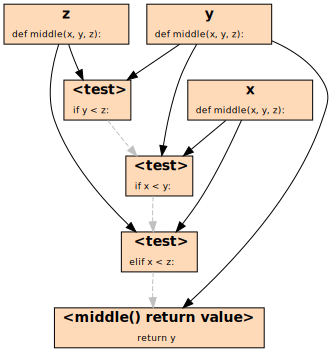

In [25]:
middle_deps().graph()

#### Slices

The method `backward_slice(*items, mode='cd')` returns a subset of dependencies, following dependencies backward from the given `items`. The extra parameter `mode` controls which dependencies are to be included:

* **`d`** = data dependencies
* **`c`** = control dependencies

In [26]:
class Dependencies(Dependencies):
    def expand_items(self, items):
        all_items = []
        for item in items:
            if isinstance(item, str):
                for var in self.all_vars():
                    (name, location) = var
                    if name == item:
                        all_items.append(var)
            else:
                all_items.append(item)

        return all_items

    def backward_slice(self, *items, mode="cd", depth=-1):
        """Create a backward slice from nodes ITEMS."""
        data = {}
        control = {}
        queue = self.expand_items(items)
        seen = set()

        while len(queue) > 0 and depth != 0:
            var = queue[0]
            queue = queue[1:]
            seen.add(var)

            if 'd' in mode:
                # Follow data dependencies
                data[var] = self.data[var]
                for next_var in data[var]:
                    if next_var not in seen:
                        queue.append(next_var)
            else:
                data[var] = set()

            if 'c' in mode:
                # Follow control dependencies
                control[var] = self.control[var]
                for next_var in control[var]:
                    if next_var not in seen:
                        queue.append(next_var)
            else:
                control[var] = set()

            depth -= 1

        return Dependencies(data, control)

### End of Excursion

### Data Dependencies

Here is an example of a data dependency in our `middle()` program. The value `y` returned by `middle()` comes from the value `y` as originally passed as argument. We use arrows $x \leftarrow y$ to indicate that a variable $x$ depends on an earlier variable $y$:

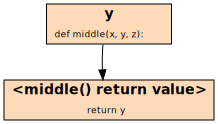

In [27]:
# ignore
middle_deps().backward_slice('<middle() return value>', mode='d').graph()

Here, we can see that the value `y` in the return statement is data dependent on the value of `y` as passed to `middle()`. An alternate interpretation of this graph is a *data flow*: The value of `y` in the upper node _flows_ into the value of `y` in the lower node.

Since we consider the values of variables at specific locations in the program, such data dependencies can also be interpreted as dependencies between _statements_ – the above `return` statement thus is data dependent on the initialization of `y` in the upper node.

### Control Dependencies

Here is an example of a control dependency. The execution of the above `return` statement is controlled by the earlier test `x < z`. We use grey dashed lines to indicate control dependencies:

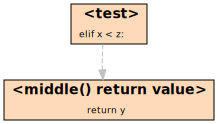

In [28]:
# ignore
middle_deps().backward_slice('<middle() return value>', mode='c', depth=1).graph()

This test in turn is controlled by earlier tests, so the full chain of control dependencies looks like this:

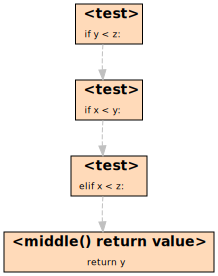

In [29]:
# ignore
middle_deps().backward_slice('<middle() return value>', mode='c').graph()

### Dependency Graphs

As the above `<test>` values (and their statements) are in turn also dependent on earlier data, namely the `x`, `y`, and `z` values as originally passed. We can draw all data and control dependencies in a single graph, called a _program dependency graph_:

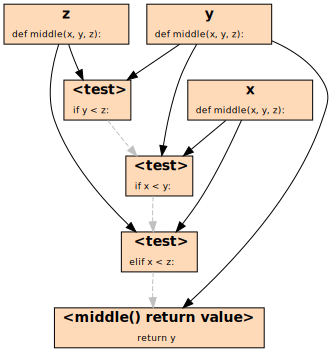

In [30]:
# ignore
middle_deps().graph()

This graph now gives us an idea on how to proceed to track the origins of the `middle()` return value at the bottom. Its value can come from any of the origins – namely the initialization of `y` at the function call, or from the `<test>` that controls it. This test in turn depends on `x` and `z` and their associated statements, which we now can check one after the other.

Note that all these dependencies in the graph are _dynamic_ dependencies – that is, they refer to statements actually evaluated in the run at hand, as well as the decisions made in that very run. There also are _static_ dependency graphs coming from static analysis of the code; but for debugging, _dynamic_ dependencies specific to the failing run are more useful.

### Showing Dependencies with Code

While a graph gives us a representation about which possible data and control flows to track, integrating dependencies with actual program code results in a compact representation that is easy to reason about.

#### Excursion: Listing Dependencies

To show dependencies as text, we introduce a method `format_var()` that shows a single node (a variable) as text. By default, a node is referenced as

```python
NAME (FUNCTION:LINENO)
```

However, within a given function, it makes no sense to re-state the function name again and again, so we have a shorthand

```python
NAME (LINENO)
```

to state a dependency to variable `NAME` in line `LINENO`.

In [31]:
class Dependencies(Dependencies):
    def format_var(self, var, current_location=None):
        """Return string for VAR in CURRENT_LOCATION."""
        name, location = var
        location_name, lineno = location
        if location_name != current_location:
            return f"{name} ({location_name}:{lineno})"
        else:
            return f"{name} ({lineno})"

`format_var()` is used extensively in this string representation of dependencies, listing all nodes and their data (`<=`) and control (`<-`) dependencies.

In [32]:
class Dependencies(Dependencies):
    def __str__(self):
        self.validate()

        out = ""
        for code_name in self.all_codes():
            if out != "":
                out += "\n"
            out += f"{code_name}():\n"

            all_vars = list(set(self.data.keys()) | set(self.control.keys()))
            all_vars.sort(key=lambda var: var[1][1])

            for var in all_vars:
                (name, location) = var
                var_code, var_lineno = location
                if var_code != code_name:
                    continue

                all_deps = ""
                for (source, arrow) in [(self.data, "<="), (self.control, "<-")]:
                    deps = ""
                    for data_dep in source[var]:
                        if deps == "":
                            deps = f" {arrow} "
                        else:
                            deps += ", "
                        deps += self.format_var(data_dep, code_name)

                    if deps != "":
                        if all_deps != "":
                            all_deps += ";"
                        all_deps += deps

                if all_deps == "":
                    continue

                out += ("    " + 
                        self.format_var(var, code_name) +
                        all_deps + "\n")

        return out

    def __repr__(self):
        # Useful for saving and restoring values
        return f"Dependencies({self.data}, {self.control})"

Here is a compact string representation of dependencies. We see how the (last) `middle() return value` has a data dependency to `y` in Line 1, and to the `<test>` in Line 5.

In [33]:
print(middle_deps())

middle():
    <test> (2) <= y (1), z (1)
    <test> (3) <= x (1), y (1); <- <test> (2)
    <test> (5) <= x (1), z (1); <- <test> (3)
    <middle() return value> (6) <= y (1); <- <test> (5)



An even more useful representation comes when integrating these dependencies as comments into the code. The method `code(item)` lists the given (function) item, including its dependencies.

In [34]:
class Dependencies(Dependencies):
    def code(self, item, mode='cd'):
        """List ITEM on standard output, including dependencies as comments."""
        all_vars = self.all_vars()
        slice_locations = set(location for name, location in all_vars)

        source_lines, first_lineno = inspect.getsourcelines(item)

        n = first_lineno
        for line in source_lines:
            line_location = (item.__name__, n)
            if line_location in slice_locations:
                prefix = "* "
            else:
                prefix = "  "

            print(f"{prefix}{n:4} ", end="")

            comment = ""
            for (mode_control, source, arrow) in [
                ('d', self.data, '<='),
                ('c', self.control, '<-')
            ]:
                if mode_control not in mode:
                    continue

                deps = ""
                for var in source:
                    name, location = var
                    if location == line_location:
                        for dep_var in source[var]:
                            if deps == "":
                                deps = arrow + " "
                            else:
                                deps += ", "
                            deps += self.format_var(dep_var, item.__name__)

                if deps != "":
                    if comment != "":
                        comment += "; "
                    comment += deps

            if comment != "":
                line = line.rstrip() + "  # " + comment

            print_content(line.rstrip(), '.py')
            print()
            n += 1

#### End of Excursion

The following listing shows such an integration. For each executed line (`*`), we see its data (`<=`) and control (`<-`) dependencies, listing the associated variables and line numbers. The comment

```python
# <= y (1); <- <test> (5)
```

for Line 6, for instance, states that the return value is data dependent on the value of `y` in Line 1, and control dependent on the test in Line 5.

Again, one can easily follow these dependencies back to track where a value came from (data dependencies) and why a statement was executed (control dependency).

In [35]:
# ignore
middle_deps().code(middle)

*    1 def middle(x, y, z):
*    2     if y < z:  # <= y (1), z (1)
*    3         if x < y:  # <= x (1), y (1); <- <test> (2)
     4             return y
*    5         elif x < z:  # <= x (1), z (1); <- <test> (3)
*    6             return y  # <= y (1); <- <test> (5)
     7     else:
     8         if x > y:
     9             return y
    10         elif x > z:
    11             return x
    12     return z


One important aspect of dependencies is that they not only point to specific sources and causes of failures – but that they also _rule out_ parts of program and state as failures.

* In the above code, Lines 8 and later have no influence on the output, simply because they were not executed.
* Furthermore, we see that we can start our investigation with Line 6, because that is the last one executed.
* The data dependencies tell us that no statement has interfered with the value of `y` between the function call and its return.
* Hence, the error must be in the conditions and the final `return` statement.

With this in mind, recall that our original invocation was `middle(2, 1, 3)`. Why and how is the above code wrong?

In [36]:
quiz("Which of the following `middle()` code lines should be fixed?",
    [
        "Line 2: `if y < z:`",
        "Line 3: `if x < y:`",
        "Line 5: `elif x < z:`",
        "Line 6: `return z`",
    ], (1 ** 0 + 1 ** 1) ** (1 ** 2 + 1 ** 3))

Indeed, from the controlling conditions, we see that `y < z`, `x >= y`, and `x < z` all hold. Hence, `y <= x < z` holds, and it is `x`, not `y`, that should be returned.

## Slices

Given a dependency graph for a particular variable, we can identify the subset of the program that could have influenced it – the so-called _slice_. In the above code listing, these code locations are highlighted with `*` characters. Only these locations are part of the slice.

Slices are central to debugging for two reasons:

* First, they _rule out_ those locations of the program that could _not_ have an effect on the failure. Hence, these locations need not be investigated as it comes to searching for the defect. Nor do they need to be considered for a fix, as any change outside of the program slice by construction cannot affect the failure.
* Second, they bring together possible origins that may be scattered across the code. Many dependencies in program code are _non-local_, with references to functions, classes, and modules defined in other locations, files, or libraries. A slice brings together all those locations in a single whole.

Here is an example of a slice – this time for our well-known `remove_html_markup()` function from [the introduction to debugging](Intro_Debugging.ipynb):

In [37]:
from Intro_Debugging import remove_html_markup

In [38]:
print_content(inspect.getsource(remove_html_markup), '.py')

def remove_html_markup(s):
    tag = False
    quote = False
    out = ""

    for c in s:
        assert tag or not quote

        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif (c == '"' or c == "'") and tag:
            quote = not quote
        elif not tag:
            out = out + c

    return out

When we invoke `remove_html_markup()` as follows...

In [39]:
remove_html_markup('<foo>bar</foo>')

'bar'

... we obtain the following dependencies:

In [40]:
# ignore
def remove_html_markup_deps():
    return Dependencies({('s', ('remove_html_markup', 136)): set(), ('tag', ('remove_html_markup', 137)): set(), ('quote', ('remove_html_markup', 138)): set(), ('out', ('remove_html_markup', 139)): set(), ('c', ('remove_html_markup', 141)): {('s', ('remove_html_markup', 136))}, ('<test>', ('remove_html_markup', 144)): {('quote', ('remove_html_markup', 138)), ('c', ('remove_html_markup', 141))}, ('tag', ('remove_html_markup', 145)): set(), ('<test>', ('remove_html_markup', 146)): {('quote', ('remove_html_markup', 138)), ('c', ('remove_html_markup', 141))}, ('<test>', ('remove_html_markup', 148)): {('c', ('remove_html_markup', 141))}, ('<test>', ('remove_html_markup', 150)): {('tag', ('remove_html_markup', 147)), ('tag', ('remove_html_markup', 145))}, ('tag', ('remove_html_markup', 147)): set(), ('out', ('remove_html_markup', 151)): {('out', ('remove_html_markup', 151)), ('c', ('remove_html_markup', 141)), ('out', ('remove_html_markup', 139))}, ('<remove_html_markup() return value>', ('remove_html_markup', 153)): {('<test>', ('remove_html_markup', 146)), ('out', ('remove_html_markup', 151))}}, {('s', ('remove_html_markup', 136)): set(), ('tag', ('remove_html_markup', 137)): set(), ('quote', ('remove_html_markup', 138)): set(), ('out', ('remove_html_markup', 139)): set(), ('c', ('remove_html_markup', 141)): set(), ('<test>', ('remove_html_markup', 144)): set(), ('tag', ('remove_html_markup', 145)): {('<test>', ('remove_html_markup', 144))}, ('<test>', ('remove_html_markup', 146)): {('<test>', ('remove_html_markup', 144))}, ('<test>', ('remove_html_markup', 148)): {('<test>', ('remove_html_markup', 146))}, ('<test>', ('remove_html_markup', 150)): {('<test>', ('remove_html_markup', 148))}, ('tag', ('remove_html_markup', 147)): {('<test>', ('remove_html_markup', 146))}, ('out', ('remove_html_markup', 151)): {('<test>', ('remove_html_markup', 150))}, ('<remove_html_markup() return value>', ('remove_html_markup', 153)): set()})

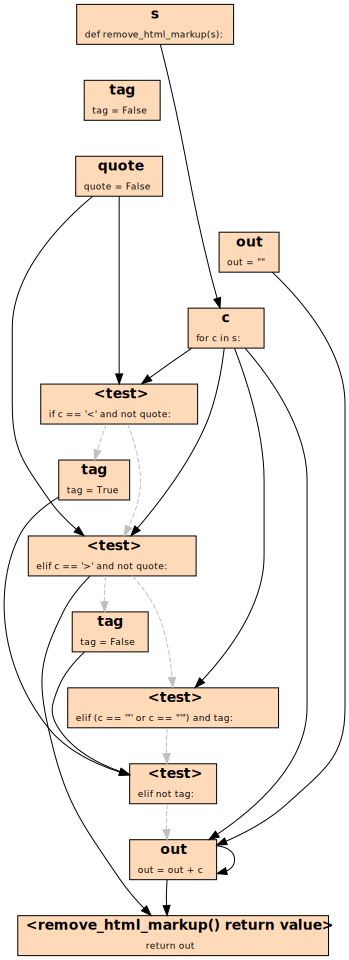

In [41]:
# ignore
remove_html_markup_deps().graph()

Again, we can read such a graph _forward_ (starting from, say, `s`) or _backward_ (starting from the return value). Starting forward, we see how the passed string `s` flows into the `for` loop, breaking `s` into individual characters `c` that are then checked on various occasions, before flowing into the `out` return value. We also see how the various `if` conditions are all influenced by `c`, `tag`, and `quote`.

In [42]:
quiz("Why does the first line `tag = False` not influence anything?",
    [
        "Because the input contains only tags",
        "Because `tag` is set to True with the first character",
        "Because `tag` is not read by any variable",
        "Because the input contains no tags",
    ], (1 << 1 + 1 >> 1))

Which are the locations that set `tag` to True? To this end, we compute the slice of `tag` at `tag = True`:

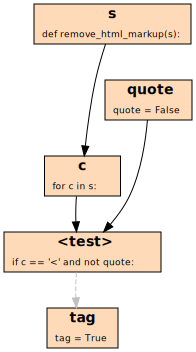

In [43]:
# ignore
tag_deps = Dependencies({('tag', ('remove_html_markup', 145)): set(), ('<test>', ('remove_html_markup', 144)): {('quote', ('remove_html_markup', 138)), ('c', ('remove_html_markup', 141))}, ('quote', ('remove_html_markup', 138)): set(), ('c', ('remove_html_markup', 141)): {('s', ('remove_html_markup', 136))}, ('s', ('remove_html_markup', 136)): set()}, {('tag', ('remove_html_markup', 145)): {('<test>', ('remove_html_markup', 144))}, ('<test>', ('remove_html_markup', 144)): set(), ('quote', ('remove_html_markup', 138)): set(), ('c', ('remove_html_markup', 141)): set(), ('s', ('remove_html_markup', 136)): set()})
tag_deps.graph()

We see where the value of `tag` comes from: from the characters `c` in `s` as well as `quote`, which all cause it to be set. Again, we can combine these dependencies and the listing in a single, compact view. Note, again, that there are no other locations in the code that could possibly have affected `tag` in our run.

In [44]:
# ignore
tag_deps.code(remove_html_markup)

*  136 def remove_html_markup(s):
   137     tag = False
*  138     quote = False
   139     out = ""
   140 
*  141     for c in s:  # <= s (136)
   142         assert tag or not quote
   143 
*  144         if c == '<' and not quote:  # <= c (141), quote (138)
*  145             tag = True  # <- <test> (144)
   146         elif c == '>' and not quote:
   147             tag = False
   148         elif (c == '"' or c == "'") and tag:
   149             quote = not quote
   150         elif not tag:
   151             out = out + c
   152 
   153     return out


In [45]:
quiz("How does the slice of `tag = True` change "
     "for a different value of `s`?",
    [
        "Not at all",
        "If `s` contains a quote, the `quote` slice is included, too",
        "If `s` contains no HTML tag, the slice will be empty"
    ], 
     [1, 2, 3][1:])

Indeed, our dynamic slices reflect dependencies as they occurred within a single execution. As the execution changes, so do the dependencies.

## Tracking Techniques

For the remainder of this chapter, let us investigate means to _determine such dependencies_ automatically – by _collecting_ them during program execution. The idea is that with a single Python call, we can collect the dependencies for some computation, and present them to programmers – as graphs or as code annotations, as shown above.

To track dependencies, for every variable, we need to keep track of its _origins_ – where it obtained its value, and which tests controlled its assignments. There are two ways to do so:

* Wrapping Data Objects
* Wrapping Data Accesses

### Wrapping Data Objects

One way to track origins is to _wrap_ each value in a class that stores both a value and the origin of the value. If a variable `x` is initialized to zero in Line 3, for instance, we could store it as
```
x = (value=0, origin=<Line 3>)
```
and if it is copied in, say, Line 5 to another variable `y`, we could store this as
```
y = (value=0, origin=<Line 3, Line 5>)
```
Such a scheme would allow us to track origins and dependencies right within the variable.

In a language like Python, it is actually possibly to subclass from basic types. Here's how we create a `MyInt` subclass of `int`:

In [46]:
class MyInt(int):
    def __new__(cls, value, *args, **kwargs):
        return super(cls, cls).__new__(cls, value)

    def __repr__(self):
        return f"{int(self)}"

In [47]:
x = MyInt(5)

We can access `x` just like any integer:

In [48]:
x, x + 1

(5, 6)

However, we can also add extra attributes to it:

In [49]:
x.origin = "Line 5"

In [50]:
x.origin

'Line 5'

Such a "wrapping" scheme has the advantage of _leaving program code untouched_ – simply pass "wrapped" objects instead of the original values. However, it also has a number of drawbacks.

* First, we must make sure that the "wrapper" objects are still compatible with the original values – notably by converting them back whenever needed. (What happens if an internal Python function expects an `int` and gets a `MyInt` instead?)
* Second, we have to make sure that origins do not get lost during computations – which involves overloading operators such as `+`, `-`, `*`, and so on. (Right now, `MyInt(1) + 1` gives us an `int` object, not a `MyInt`.)
* Third, we have to do this for _all_ data types of a language, which is pretty tedious.
* Fourth and last, however, we want to track whenever a value is assigned to another variable. Python has no support for this, and thus our dependencies will necessarily be incomplete.

### Wrapping Data Accesses

An alternate way of tracking origins is to _instrument_ the source code such that all _data read and write operations are tracked_. That is, the original data stays unchanged, but we change the code instead.

In essence, for every occurrence of a variable `x` being _read_, we replace it with

```python
_data.get('x', x)  # returns x
```

and for every occurrence of a value being _written_ to `x`, we replace the value with

```python
_data.set('x', value)  # returns value
```

and let the `_data` object track these reads and writes.

Hence, an assignment such as 

```python
a = b + c
```

would get rewritten to

```python
a = _data.set('a', _data.get('b', b) + _data.get('c', c))
```

and with every access to `_data`, we would track 

1. the current _location_ in the code, and 
2. whether the respective variable was read or written.

For the above statement, we could deduce that `b` and `c` were read, and `a` was written – which makes `a` data dependent on `b` and `c`.

The advantage of such instrumentation is that it works with _arbitrary objects_ (in Python, that is) – we do not case whether `a`, `b`, and `c` would be integers, floats, strings, lists. or any other type for which `+` would be defined. Also, the code semantics remain entirely unchanged.

The disadvantage, however, is that it takes a bit of effort to exactly separate reads and writes into individual groups, and that a number of language features have to be handled separately. This is what we do in the remainder of this chapter.

## A Data Tracker

To implement `_data` accesses as shown above, we introduce the `DataTracker` class. As its name suggests, it keeps track of variables being read and written, and provides methods to determine the code location where this tool place.

In [51]:
class DataTracker(object):
    def __init__(self, log=False):
        """Initialize. If LOG is set, turn on logging."""
        self.log = log

The method `caller_frame()` walks up the current call stack until it finds a method or function that is not part of `DataTracker`. `caller_location()` returns its location.

In [52]:
class DataTracker(DataTracker):
    def caller_frame(self):
        """Return the frame of the caller."""
        frame = inspect.currentframe()
        while ('self' in frame.f_locals and 
               isinstance(frame.f_locals['self'], self.__class__)):
            frame = frame.f_back
        return frame

    def caller_location(self):
        """Return the location (code name, lineno) of the caller."""
        frame = self.caller_frame()
        if frame.f_code.co_name in globals():
            return frame.f_code.co_name, frame.f_lineno
        else:
            return frame.f_code.co_name, frame.f_lineno

`set()` is invoked when a variable is set, as in

```python
pi = _data.set('pi', 3.1415)
```

By default, we simply log the access.

In [53]:
class DataTracker(DataTracker):
    def set(self, name, value, loads=None):
        """Track setting NAME to VALUE."""
        if self.log:
            code_name, lineno = self.caller_location()
            print(f"{code_name}:{lineno}: setting {name}")

        return value

`get()` is invoked when a variable is retrieved, as in

```python
print(_data.get('pi', pi))
```
By default, we simply log the access.

In [54]:
class DataTracker(DataTracker):
    def get(self, name, value):
        """Track getting VALUE from NAME."""

        if self.log:
            code_name, lineno = self.caller_location()
            print(f"{code_name}:{lineno}: getting {name}")

        return value

In [55]:
class DataTracker(DataTracker):
    def __repr__(self):
        return super().__repr__()

Here's an example of a logging `DataTracker`:

In [56]:
_test_data = DataTracker(log=True)
x = _test_data.set('x', 1)

<module>:2: setting x


In [57]:
_test_data.get('x', x)

<module>:1: getting x


1

## Instrumenting Source Code

How do we transform source code such that read and write accesses to variables would be automatically rewritten?  To this end, we inspect the internal representation of source code, namely the _abstract syntax trees_ (ASTs). An AST represents the code as a tree, with specific node types for each syntactical element.

In [58]:
import ast
import astor

Here is the tree representation for our `middle()` function. It starts with a `FunctionDef` node at the top (with the name `"middle"` and the three arguments `x`, `y`, `z` as children), followed by a subtree for each of the `If` statements, each of which contains a branch for when their condition evaluates to`True` and a branch for when their condition evaluates to `False`.

In [59]:
from bookutils import rich_output

In [60]:
if rich_output():
    from showast import show_ast
else:
    def show_ast(tree):
        ast.dump(tree)

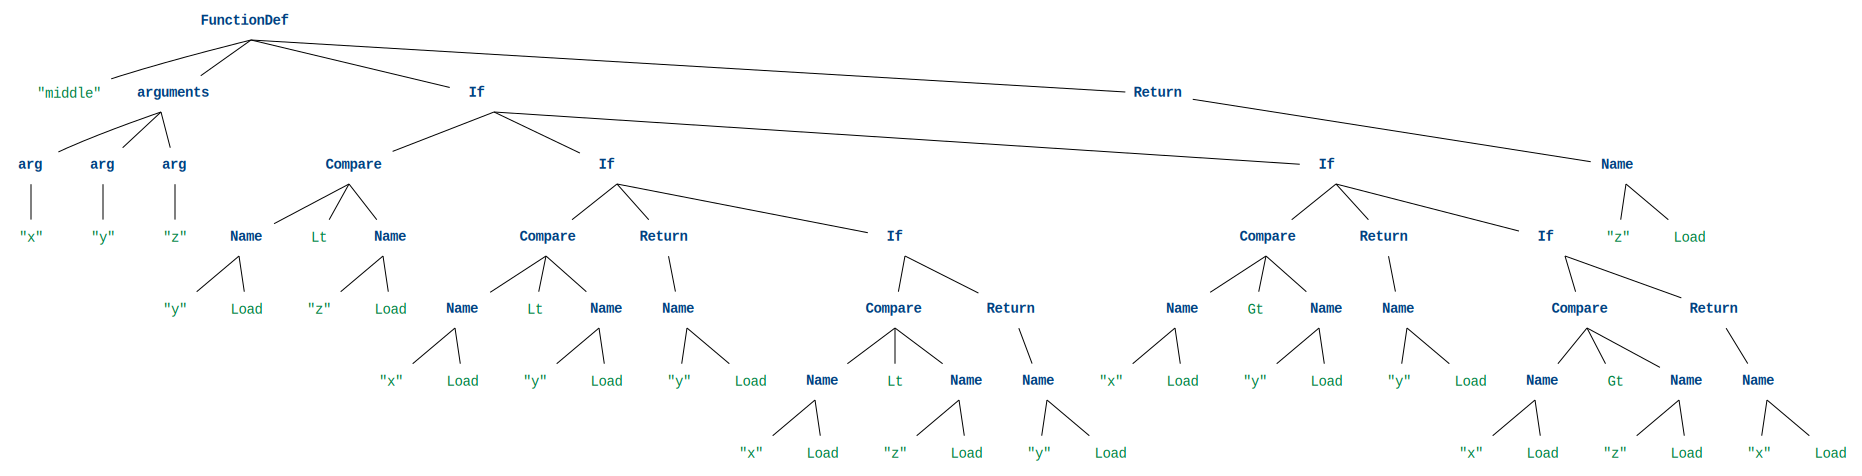

In [61]:
middle_tree = ast.parse(inspect.getsource(middle))
show_ast(middle_tree)

At the very bottom of the tree, you can see a number of `Name` nodes, referring individual variables. These are the ones we want to transform.

### Tracking Variable Access

Our goal is to _traverse_ the tree, identify all `Name` nodes, and convert them to respective `_data` accesses.
To this end, we manipulate the AST through the Python modules `ast` and `astor`. The [official Python `ast` reference](http://docs.python.org/3/library/ast) is complete, but a bit brief; the documentation ["Green Tree Snakes - the missing Python AST docs"](https://greentreesnakes.readthedocs.io/en/latest/) provides an excellent introduction.

The Python `ast` class provides a class `NodeTransformer` that allows such transformations. Subclassing from it, we provide a method `visit_Name()` that will be invoked for all `Name` nodes – and replace it by a new subtree from `make_get_data()`:

In [62]:
from ast import NodeTransformer, NodeVisitor

In [63]:
DATA_TRACKER = '_data'

In [64]:
class TrackGetTransformer(NodeTransformer):
    def visit_Name(self, node):
        self.generic_visit(node)

        if node.id in dir(__builtins__):
            # Do not change built-in names
            return node

        if node.id == DATA_TRACKER:
            # Do not change own accesses
            return node

        if not isinstance(node.ctx, Load):
            # Only change loads (not stores, not deletions)
            return node

        new_node = make_get_data(node.id)
        ast.copy_location(new_node, node)
        return new_node

Our function `make_get_data(id, method)` returns a new subtree equivalent to the Python code `_data.method('id', id)`.

In [65]:
from ast import Module, Name, Load, Store, Tuple, \
    Attribute, With, withitem, keyword, Call, Expr

In [66]:
# Starting with Python 3.8, these will become Constant
from ast import Num, Str, NameConstant

In [67]:
def make_get_data(id, method='get'):
    return Call(func=Attribute(value=Name(id=DATA_TRACKER, ctx=Load()), 
                               attr=method, ctx=Load()),
                args=[Str(s=id), Name(id=id, ctx=Load())],
                keywords=[])

This is the tree that `make_get_data()` produces:

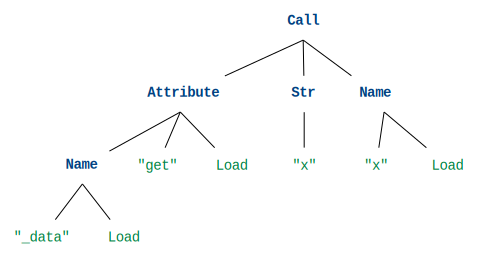

In [68]:
show_ast(Module(body=[make_get_data("x")]))

How do we know that this is a correct subtree? We can carefully read the [official Python `ast` reference](http://docs.python.org/3/library/ast) and then proceed by trial and error (and apply [delta debugging](DeltaDebugger.ipynb) to determine error causes). Or – pro tip! – we can simply take a piece of Python code, parse it and use `ast.dump()` to print out how to construct the resulting AST:

In [69]:
print(ast.dump(ast.parse("_data.get('x', x)")))

Module(body=[Expr(value=Call(func=Attribute(value=Name(id='_data', ctx=Load()), attr='get', ctx=Load()), args=[Str(s='x'), Name(id='x', ctx=Load())], keywords=[]))])


If you compare the above output with the code of `make_get_data()`, above, you will find out where the source of `make_get_data()` comes from.

Let us put `TrackGetTransformer` to action. Its `visit()` method calls `visit_Name()`, which then in turn transforms the `Name` nodes as we want it. This happens in place.

In [70]:
TrackGetTransformer().visit(middle_tree);

To see the effect of our transformations, we introduce a method `dump_tree()` which outputs the tree – and also compiles it to check for any inconsistencies.

In [71]:
def dump_tree(tree):
    print_content(astor.to_source(tree), '.py')
    ast.fix_missing_locations(tree)  # Must run this before compiling
    _ = compile(tree, '<dump_tree>', 'exec')

We see that our transformer has properly replaced all 

In [72]:
dump_tree(middle_tree)

def middle(x, y, z):
    if _data.get('y', y) < _data.get('z', z):
        if _data.get('x', x) < _data.get('y', y):
            return _data.get('y', y)
        elif _data.get('x', x) < _data.get('z', z):
            return _data.get('y', y)
    elif _data.get('x', x) > _data.get('y', y):
        return _data.get('y', y)
    elif _data.get('x', x) > _data.get('z', z):
        return _data.get('x', x)
    return _data.get('z', z)

Let us now execute this code together with the `DataTracker()` class we previously introduced. The class `DataTrackerTester()` takes a (transformed) tree and a function. Using it as

```python
with DataTrackerTester(tree, func):
    func(...)
```

first executes the code in _tree_ (possibly instrumenting `func`) and then the `with` body. At the end, `func` is restored to its previous (non-instrumented) version.

In [73]:
class DataTrackerTester(object):
    def __init__(self, tree, func, log=True):
        self.code = compile(tree, '<DataTracker>', 'exec')
        self.func = func
        self.log = log

    def make_data_tracker(self):
        return DataTracker(log=self.log)

    def __enter__(self):
        """Rewrite function"""
        tracker = self.make_data_tracker()
        globals()[DATA_TRACKER] = tracker
        exec(self.code, globals())
        return tracker

    def __exit__(self, exc_type, exc_value, traceback):
        """Restore function"""
        globals()[self.func.__name__] = self.func
        del globals()[DATA_TRACKER]

Here is our `middle()` function:

In [74]:
print_content(inspect.getsource(middle), '.py', start_line_number=1)

 1  def middle(x, y, z):
 2      if y < z:
 3          if x < y:
 4              return y
 5          elif x < z:
 6              return y
 7      else:
 8          if x > y:
 9              return y
10          elif x > z:
11              return x
12      return z

And here is our instrumented `middle_tree` executed with a `DataTracker` object. We see how the `middle()` tests access one argument after another.

In [75]:
with DataTrackerTester(middle_tree, middle):
    middle(2, 1, 3)

middle:2: getting y
middle:2: getting z
middle:3: getting x
middle:3: getting y
middle:5: getting x
middle:5: getting z
middle:6: getting y


After `DataTrackerTester` is done, `middle` is reverted to its non-instrumented version:

In [76]:
middle(2, 1, 3)

1

For a complete picture of what happens during executions, we implement a number of additional code transformers.

For each assignment statement `x = y`, we change it to `x = _data.set('x', y)`. This allows to __track assignments__.

### Excursion: Tracking Assignments

For the remaining transformers, we follow the same steps as for `TrackGetTransformer`, except that our `visit_...()` methods focus on different nodes, and return different subtrees. Here, we focus on assignment nodes.

We want to transform assignments `x = value` into `_data.set('x', value)` to track assignments to `x`.

If the left hand side of the assignment is more complex, as in `x[y] = value`, we want to ensure the read access to `x` and `y` is also tracked. By transforming `x[y] = value` into `_data.set('x', value, loads=(x, y))`, we ensure that `x` and `y` are marked as read (as the otherwise ignored `loads` argument would be changed to `_data.get()` calls for `x` and `y`).

Using `ast.dump()`, we reveal what the corresponding syntax tree has to look like:

In [77]:
print(ast.dump(ast.parse("_data.set('x', value, loads=(a, b))")))

Module(body=[Expr(value=Call(func=Attribute(value=Name(id='_data', ctx=Load()), attr='set', ctx=Load()), args=[Str(s='x'), Name(id='value', ctx=Load())], keywords=[keyword(arg='loads', value=Tuple(elts=[Name(id='a', ctx=Load()), Name(id='b', ctx=Load())], ctx=Load()))]))])


Using this structure, we can write a function `make_set_data()` which constructs such a subtree.

In [78]:
def make_set_data(id, value, loads=None, method='set'):
    """Construct a subtree _data.METHOD('ID', VALUE). 
    If LOADS is set to [X1, X2, ...], make it
    _data.METHOD('ID', VALUE, loads=(X1, X2, ...))
    """
    keywords=[]

    if loads:
        keywords = [
            keyword(arg='loads',
                    value=Tuple(
                        elts=[Name(id=load, ctx=Load()) for load in loads],
                        ctx=Load()
                    ))
        ]

    new_node = Call(func=Attribute(value=Name(id=DATA_TRACKER, ctx=Load()),
                                   attr=method, ctx=Load()),
                    args=[Str(s=id), value],
                    keywords=keywords)

    ast.copy_location(new_node, value)

    return new_node

The problem is, however: How do we get the name of the variable being assigned to? The left hand side of an assignment can be a complex expression such as `x[i]`. We use the leftmost name of the left hand side as name to be assigned to.

In [79]:
class LeftmostNameVisitor(NodeVisitor):
    def __init__(self):
        super().__init__()
        self.leftmost_name = None
        
    def visit_Name(self, node):
        if self.leftmost_name is None:
            self.leftmost_name = node.id
        self.generic_visit(node)

def leftmost_name(tree):
    visitor = LeftmostNameVisitor()
    visitor.visit(tree)
    return visitor.leftmost_name

In [80]:
leftmost_name(ast.parse('a[x] = 25'))

'a'

Python also allows _tuple assignments_, as in `(a, b, c) = (1, 2, 3)`. We extract all variables being stored (that is, expressions whose `ctx` attribute is `Store()`) and extract their (leftmost) names.

In [81]:
class StoreVisitor(NodeVisitor):
    def __init__(self):
        super().__init__()
        self.names = set()
        
    def visit(self, node):
        if hasattr(node, 'ctx') and isinstance(node.ctx, Store):
            name = leftmost_name(node)
            if name is not None:
                self.names.add(name)

        self.generic_visit(node)

def store_names(tree):
    visitor = StoreVisitor()
    visitor.visit(tree)
    return visitor.names

In [82]:
store_names(ast.parse('a[x], b[y], c = 1, 2, 3'))

{'a', 'b', 'c'}

For complex assignments, we also want to access the names read in the left hand side of an expression.

In [83]:
class LoadVisitor(NodeVisitor):
    def __init__(self):
        super().__init__()
        self.names = set()

    def visit(self, node):
        if hasattr(node, 'ctx') and isinstance(node.ctx, Load):
            name = leftmost_name(node)
            if name is not None:
                self.names.add(name)

        self.generic_visit(node)

def load_names(tree):
    visitor = LoadVisitor()
    visitor.visit(tree)
    return visitor.names

In [84]:
load_names(ast.parse('a[x], b[y], c = 1, 2, 3'))

{'a', 'b', 'x', 'y'}

With this, we can now define `TrackSetTransformer` as a transformer for regular assignments. Note that in Python, an assignment can have multiple targets, as in `a = b = c`; we assign the data dependencies of `c` to them all.

In [85]:
class TrackSetTransformer(NodeTransformer):
    def visit_Assign(self, node):
        value = astor.to_source(node.value)
        if value.startswith(DATA_TRACKER + '.set'):
            return node  # Do not apply twice

        for target in node.targets:
            loads = load_names(target)
            for store_name in store_names(target):
                node.value = make_set_data(store_name, node.value, 
                                           loads=loads)
                loads = set()

        return node

The special form of "augmented assign" needs special treatment. We change statements of the form `x += y` to `x += _data.augment('x', y)`.

In [86]:
class TrackSetTransformer(TrackSetTransformer):
    def visit_AugAssign(self, node):
        value = astor.to_source(node.value)
        if value.startswith(DATA_TRACKER):
            return node  # Do not apply twice

        id = leftmost_name(node.target)
        node.value = make_set_data(id, node.value, method='augment')

        return node

The corresponding `augment()` method uses a combination of `set()` and `get()` to reflect the semantics.

In [87]:
class DataTracker(DataTracker):
    def augment(self, name, value):
        """Track augmenting NAME with VALUE."""
        self.set(name, self.get(name, value))
        return value

Here's both of these transformers in action. Our original function has a number of assignments:

In [88]:
def assign_test(x):
    fourty_two = forty_two = 42
    a, b, c = 1, 2, 3
    c[d[x]].attr = 47
    foo *= bar + 1

In [89]:
assign_tree = ast.parse(inspect.getsource(assign_test))

In [90]:
TrackSetTransformer().visit(assign_tree)
dump_tree(assign_tree)

def assign_test(x):
    fourty_two = forty_two = _data.set('forty_two', _data.set('fourty_two', 42)
        )
    a, b, c = _data.set('a', _data.set('b', _data.set('c', (1, 2, 3))))
    c[d[x]].attr = _data.set('c', 47, loads=(c, x, d))
    foo *= _data.augment('foo', bar + 1)

If we later apply our transformer for data accesses, we can see that we track all variable reads and writes.

In [91]:
TrackGetTransformer().visit(assign_tree)
dump_tree(assign_tree)

def assign_test(x):
    fourty_two = forty_two = _data.set('forty_two', _data.set('fourty_two', 42)
        )
    a, b, c = _data.set('a', _data.set('b', _data.set('c', (1, 2, 3))))
    _data.get('c', c)[_data.get('d', d)[_data.get('x', x)]].attr = _data.set(
        'c', 47, loads=(_data.get('c', c), _data.get('x', x), _data.get('d',
        d)))
    foo *= _data.augment('foo', _data.get('bar', bar) + 1)

### End of Excursion

Each return statement `return x` is transformed to `return _data.set('<return_value>', x)`. This allows to __track return values__.

### Excursion: Tracking Return Values

Our `TrackReturnTransformer` also makes use of `make_set_data()`.

In [92]:
class TrackReturnTransformer(NodeTransformer):
    def __init__(self):
        self.function_name = None
        super().__init__()

    def visit_FunctionDef(self, node):
        outer_name = self.function_name
        self.function_name = node.name  # Save current name
        self.generic_visit(node)
        self.function_name = outer_name
        return node

    def visit_AsyncFunctionDef(self, node):
        return self.visit_FunctionDef(node)

    def return_value(self, tp="return"):
        if self.function_name is None:
            return f"<{tp} value>"
        else:
            return f"<{self.function_name}() {tp} value>"

    def visit_return_or_yield(self, node, tp="return"):
        if node.value is not None:
            value = astor.to_source(node.value)
            if not value.startswith(DATA_TRACKER + '.set'):
                node.value = make_set_data(self.return_value(tp), node.value)

        return node

    def visit_Return(self, node):
        return self.visit_return_or_yield(node, tp="return")

    def visit_Yield(self, node):
        return self.visit_return_or_yield(node, tp="yield")

    def visit_YieldFrom(self, node):
        return self.visit_return_or_yield(node, tp="yield")

This is the effect of `TrackReturnTransformer`. We see that all return values are saved, and thus all locations of the corresponding return statements are tracked.

In [93]:
TrackReturnTransformer().visit(middle_tree)
dump_tree(middle_tree)

def middle(x, y, z):
    if _data.get('y', y) < _data.get('z', z):
        if _data.get('x', x) < _data.get('y', y):
            return _data.set('<middle() return value>', _data.get('y', y))
        elif _data.get('x', x) < _data.get('z', z):
            return _data.set('<middle() return value>', _data.get('y', y))
    elif _data.get('x', x) > _data.get('y', y):
        return _data.set('<middle() return value>', _data.get('y', y))
    elif _data.get('x', x) > _data.get('z', z):
        return _data.set('<middle() return value>', _data.get('x', x))
    return _data.set('<middle() return value>', _data.get('z', z))

In [94]:
with DataTrackerTester(middle_tree, middle):
    middle(2, 1, 3)

middle:2: getting y
middle:2: getting z
middle:3: getting x
middle:3: getting y
middle:5: getting x
middle:5: getting z
middle:6: getting y
middle:6: setting <middle() return value>


### End of Excursion

To track __control dependencies__, for every block controlled by an `if`, `while`, or `for`:

1. We wrap their tests in a `_data.test()` wrapper. This allows us to assign pseudo-variables like `<test>` which hold the conditions.
2. We wrap their controlled blocks in a `with` statement. This allows us to track the variables read right before the `with` (= the controlling variables), and to restore the current controlling variables when the block is left.

A statement

```python
if cond:
    body
```

thus becomes

```python
if _data.test(cond):
    with _data:
        body
```

### Excursion: Tracking Control

To modify control statements, we traverse the tree, looking for `If` nodes:

In [95]:
class TrackControlTransformer(NodeTransformer):
    def visit_If(self, node):
        self.generic_visit(node)
        node.test = self.make_test(node.test)
        node.body = self.make_with(node.body)
        node.orelse = self.make_with(node.orelse)
        return node

The subtrees come from helper functions `make_with()` and `make_test()`. Again, all these subtrees are obtained via `ast.dump()`.

In [96]:
class TrackControlTransformer(TrackControlTransformer):
    def make_with(self, block):
        """Create a subtree 'with _data: BLOCK'"""
        if len(block) == 0:
            return []

        block_as_text = astor.to_source(block[0])
        if block_as_text.startswith('with ' + DATA_TRACKER):
            return block  # Do not apply twice

        new_node = With(
            items=[
                withitem(
                    context_expr=Name(id=DATA_TRACKER, ctx=Load()),
                    optional_vars=None)
            ],
            body=block
        )
        ast.copy_location(new_node, block[0])
        return [new_node]

In [97]:
class TrackControlTransformer(TrackControlTransformer):
    def make_test(self, test):
        test_as_text = astor.to_source(test)
        if test_as_text.startswith(DATA_TRACKER + '.test'):
            return test  # Do not apply twice

        new_test = Call(func=Attribute(value=Name(id=DATA_TRACKER, ctx=Load()),
                                       attr='test',
                                       ctx=Load()),
                         args=[test],
                         keywords=[])
        ast.copy_location(new_test, test)
        return new_test

`while` loops are handled just like `if` constructs.

In [98]:
class TrackControlTransformer(TrackControlTransformer):
    def visit_While(self, node):
        self.generic_visit(node)
        node.test = self.make_test(node.test)
        node.body = self.make_with(node.body)
        node.orelse = self.make_with(node.orelse)
        return node

`for` loops gets a different treatment, as there is no condition that would control the body. Still, we ensure that setting the iterator variable is properly tracked.

In [99]:
class TrackControlTransformer(TrackControlTransformer):
    # regular `for` loop
    def visit_For(self, node):
        self.generic_visit(node)
        id = astor.to_source(node.target).strip()
        node.iter = make_set_data(id, node.iter)

        # Uncomment if you want iterators to control their bodies
        # node.body = self.make_with(node.body)
        # node.orelse = self.make_with(node.orelse)
        return node

    # `for` loops in async functions
    def visit_AsyncFor(self, node):
        return self.visit_For(node)

    # `for` clause in comprehensions
    def visit_comprehension(self, node):
        self.generic_visit(node)
        id = astor.to_source(node.target).strip()
        node.iter = make_set_data(id, node.iter)
        return node

Here is the effect of `TrackControlTransformer`:

In [100]:
TrackControlTransformer().visit(middle_tree)
dump_tree(middle_tree)

def middle(x, y, z):
    if _data.test(_data.get('y', y) < _data.get('z', z)):
        with _data:
            if _data.test(_data.get('x', x) < _data.get('y', y)):
                with _data:
                    return _data.set('<middle() return value>', _data.get(
                        'y', y))
            else:
                with _data:
                    if _data.test(_data.get('x', x) < _data.get('z', z)):
                        with _data:
                            return _data.set('<middle() return value>',
                                _data.get('y', y))
    else:
        with _data:
            if _data.test(_data.get('x', x) > _data.get('y', y)):
                with _data:
                    return _data.set('<middle() return value>', _data.get(
                        'y', y))
            else:
                with _data:
                    if _data.test(_data.get('x', x) > _data.get('z', z)):
                        with _data:
                            retu

We extend `DataTracker` to also log these events:

In [101]:
class DataTracker(DataTracker):
    def test(self, cond):
        if self.log:
            code_name, lineno = self.caller_location()
            print(f"{code_name}:{lineno}: testing condition")

        return cond

In [102]:
class DataTracker(DataTracker):
    def __enter__(self):
        if self.log:
            code_name, lineno = self.caller_location()
            print(f"{code_name}:{lineno}: entering block")

    def __exit__(self, exc_type, exc_value, traceback):
        if self.log:
            code_name, lineno = self.caller_location()
            print(f"{code_name}:{lineno}: exiting block")

In [103]:
with DataTrackerTester(middle_tree, middle):
    middle(2, 1, 3)

middle:2: getting y
middle:2: getting z
middle:2: testing condition
middle:3: entering block
middle:3: getting x
middle:3: getting y
middle:3: testing condition
middle:5: entering block
middle:5: getting x
middle:5: getting z
middle:5: testing condition
middle:6: entering block
middle:6: getting y
middle:6: setting <middle() return value>
middle:6: exiting block
middle:6: exiting block
middle:6: exiting block


### End of Excursion

We also want to be able to __track calls__ across multiple functions. To this end, we wrap each call

```python
func(arg1, arg2, ...)
```

into

```python
_data.ret(_data.call(func)(_data.arg(arg1), _data.arg(arg2), ...))
```

each of which simply pass through their given argument, but which allow to track the beginning of calls (`call()`), the computation of arguments (`arg()`), and the return of the call (`ret()`), respectively.

### Excursion: Tracking Calls and Arguments

Our `TrackCallTransformer` visits all `Call` nodes, applying the transformations as shown above.

In [104]:
class TrackCallTransformer(NodeTransformer):
    def make_call(self, node, func, pos=None, kw=None):
        """Return _data.call(FUNC)(NODE)"""
        keywords = []

        # `Num()` and `Str()` are deprecated in favor of `Constant()`
        if pos:
            keywords.append(keyword(arg='pos', value=Num(pos)))
        if kw:
            keywords.append(keyword(arg='kw', value=Str(kw)))

        return Call(func=Attribute(value=Name(id=DATA_TRACKER,
                                              ctx=Load()),
                                   attr=func,
                                   ctx=Load()),
                     args=[node],
                     keywords=keywords)

    def visit_Call(self, node):
        self.generic_visit(node)

        call_as_text = astor.to_source(node)
        if call_as_text.startswith(DATA_TRACKER + '.ret'):
            return node  # Already applied

        func_as_text = astor.to_source(node)
        if func_as_text.startswith(DATA_TRACKER + '.'):
            return node  # Own function

        new_args = []
        for n, arg in enumerate(node.args):
            new_args.append(self.make_call(arg, 'arg', pos=n + 1))
        node.args = new_args

        for kw in node.keywords:
            id = kw.arg if hasattr(kw, 'arg') else None
            kw.value = self.make_call(kw.value, 'arg', kw=id)

        node.func = self.make_call(node.func, 'call')
        return self.make_call(node, 'ret')

Our example function `middle()` does not contain any calls, but here is a function that invokes `middle()` twice:

In [105]:
def test_call():
    x = middle(1, 2, z=middle(1, 2, 3))
    return x

In [106]:
call_tree = ast.parse(inspect.getsource(test_call))
dump_tree(call_tree)

def test_call():
    x = middle(1, 2, z=middle(1, 2, 3))
    return x

If we invoke `TrackCallTransformer` on this testing function, we get the following transformed code:

In [107]:
TrackCallTransformer().visit(call_tree);

In [108]:
dump_tree(call_tree)

def test_call():
    x = _data.ret(_data.call(middle)(_data.arg(1, pos=1), _data.arg(2, pos=
        2), z=_data.arg(_data.ret(_data.call(middle)(_data.arg(1, pos=1),
        _data.arg(2, pos=2), _data.arg(3, pos=3))), kw='z')))
    return x

In [109]:
def f():
    return math.isclose(1, 1.0)

In [110]:
f_tree = ast.parse(inspect.getsource(f))
dump_tree(f_tree)

def f():
    return math.isclose(1, 1.0)

In [111]:
TrackCallTransformer().visit(f_tree);

In [112]:
dump_tree(f_tree)

def f():
    return _data.ret(_data.call(math.isclose)(_data.arg(1, pos=1), _data.
        arg(1.0, pos=2)))

As before, our default `arg()`, `ret()`, and `call()` methods simply log the event and pass through the given value.

In [113]:
class DataTracker(DataTracker):
    def arg(self, value, pos=None, kw=None):
        if self.log:
            code_name, lineno = self.caller_location()
            info = ""
            if pos:
                info += f" #{pos}"
            if kw:
                info += f" {repr(kw)}"

            print(f"{code_name}:{lineno}: pushing arg{info}")

        return value

In [114]:
class DataTracker(DataTracker):
    def ret(self, value):
        if self.log:
            code_name, lineno = self.caller_location()
            print(f"{code_name}:{lineno}: returned from call")

        return value

In [115]:
class DataTracker(DataTracker):
    def call(self, func):
        if self.log:
            code_name, lineno = self.caller_location()
            print(f"{code_name}:{lineno}: calling {func}")

        return func

In [116]:
with DataTrackerTester(call_tree, test_call):
    test_call()

test_call:2: calling <function middle at 0x7fbc454c4840>
test_call:2: pushing arg #1
test_call:2: pushing arg #2
test_call:2: calling <function middle at 0x7fbc454c4840>
test_call:2: pushing arg #1
test_call:2: pushing arg #2
test_call:2: pushing arg #3
test_call:2: returned from call
test_call:2: pushing arg 'z'
test_call:2: returned from call


### End of Excursion

On the receiving end, for each function argument `x`, we insert a call `_data.param('x', x, [position info])` to initialize `x`. This is useful for __tracking parameters across function calls.__

### Excursion: Tracking Parameters

Again, we use `ast.dump()` to determine the correct syntax tree:

In [117]:
print(ast.dump(ast.parse("_data.param('x', x, pos=1, last=True)")))

Module(body=[Expr(value=Call(func=Attribute(value=Name(id='_data', ctx=Load()), attr='param', ctx=Load()), args=[Str(s='x'), Name(id='x', ctx=Load())], keywords=[keyword(arg='pos', value=Num(n=1)), keyword(arg='last', value=NameConstant(value=True))]))])


In [118]:
class TrackParamsTransformer(NodeTransformer):
    def visit_FunctionDef(self, node):
        self.generic_visit(node)

        named_args = []
        for child in ast.iter_child_nodes(node.args):
            if isinstance(child, ast.arg):
                named_args.append(child)

        create_stmts = []
        for n, child in enumerate(named_args):
            keywords=[keyword(arg='pos', value=Num(n=n + 1))]
            if child is node.args.vararg:
                keywords.append(keyword(arg='vararg', value=Str(s='*')))
            if child is node.args.kwarg:
                keywords.append(keyword(arg='vararg', value=Str(s='**')))
            if n == len(named_args) - 1:
                keywords.append(keyword(arg='last',
                                        value=NameConstant(value=True)))

            create_stmt = Expr(
                value=Call(
                    func=Attribute(value=Name(id=DATA_TRACKER, ctx=Load()),
                                   attr='param', ctx=Load()),
                    args=[Str(s=child.arg),
                          Name(id=child.arg, ctx=Load())
                         ],
                    keywords=keywords
                )
            )
            ast.copy_location(create_stmt, node)
            create_stmts.append(create_stmt)

        node.body = create_stmts + node.body
        return node

This is the effect of `TrackParamsTransformer()`. You see how the first three parameters are all initialized.

In [119]:
TrackParamsTransformer().visit(middle_tree)
dump_tree(middle_tree)

def middle(x, y, z):
    _data.param('x', x, pos=1)
    _data.param('y', y, pos=2)
    _data.param('z', z, pos=3, last=True)
    if _data.test(_data.get('y', y) < _data.get('z', z)):
        with _data:
            if _data.test(_data.get('x', x) < _data.get('y', y)):
                with _data:
                    return _data.set('<middle() return value>', _data.get(
                        'y', y))
            else:
                with _data:
                    if _data.test(_data.get('x', x) < _data.get('z', z)):
                        with _data:
                            return _data.set('<middle() return value>',
                                _data.get('y', y))
    else:
        with _data:
            if _data.test(_data.get('x', x) > _data.get('y', y)):
                with _data:
                    return _data.set('<middle() return value>', _data.get(
                        'y', y))
            else:
                with _data:
                    if _data.test(_dat

By default, the `DataTracker` `param()` method simply calls `set()` to set variables.

In [120]:
class DataTracker(DataTracker):
    def param(self, name, value, pos=None, vararg="", last=False):
        if self.log:
            code_name, lineno = self.caller_location()
            info = ""
            if pos is not None:
                info += f" #{pos}"

            print(f"{code_name}:{lineno}: initializing {vararg}{name}{info}")

        return self.set(name, value)

In [121]:
with DataTrackerTester(middle_tree, middle):
    middle(2, 1, 3)

middle:1: initializing x #1
middle:1: setting x
middle:1: initializing y #2
middle:1: setting y
middle:1: initializing z #3
middle:1: setting z
middle:2: getting y
middle:2: getting z
middle:2: testing condition
middle:3: entering block
middle:3: getting x
middle:3: getting y
middle:3: testing condition
middle:5: entering block
middle:5: getting x
middle:5: getting z
middle:5: testing condition
middle:6: entering block
middle:6: getting y
middle:6: setting <middle() return value>
middle:6: exiting block
middle:6: exiting block
middle:6: exiting block


In [122]:
def args_test(x, *args, **kwargs):
    print(x, *args, **kwargs)

In [123]:
args_tree = ast.parse(inspect.getsource(args_test))
TrackParamsTransformer().visit(args_tree)
dump_tree(args_tree)

def args_test(x, *args, **kwargs):
    _data.param('x', x, pos=1)
    _data.param('args', args, pos=2, vararg='*')
    _data.param('kwargs', kwargs, pos=3, vararg='**', last=True)
    print(x, *args, **kwargs)

In [124]:
with DataTrackerTester(args_tree, args_test):
    args_test(1, 2, 3)

args_test:1: initializing x #1
args_test:1: setting x
args_test:1: initializing *args #2
args_test:1: setting args
args_test:1: initializing **kwargs #3
args_test:1: setting kwargs
1 2 3


### End of Excursion

What do we obtain after we have applied all these transformers on `middle()`? We see that the code now contains quite a load of instrumentation.

In [125]:
dump_tree(middle_tree)

def middle(x, y, z):
    _data.param('x', x, pos=1)
    _data.param('y', y, pos=2)
    _data.param('z', z, pos=3, last=True)
    if _data.test(_data.get('y', y) < _data.get('z', z)):
        with _data:
            if _data.test(_data.get('x', x) < _data.get('y', y)):
                with _data:
                    return _data.set('<middle() return value>', _data.get(
                        'y', y))
            else:
                with _data:
                    if _data.test(_data.get('x', x) < _data.get('z', z)):
                        with _data:
                            return _data.set('<middle() return value>',
                                _data.get('y', y))
    else:
        with _data:
            if _data.test(_data.get('x', x) > _data.get('y', y)):
                with _data:
                    return _data.set('<middle() return value>', _data.get(
                        'y', y))
            else:
                with _data:
                    if _data.test(_dat

And when we execute this code, we see that we can track quite a number of events, while the code semantics stay unchanged.

In [126]:
with DataTrackerTester(middle_tree, middle):
    m = middle(2, 1, 3)
m

middle:1: initializing x #1
middle:1: setting x
middle:1: initializing y #2
middle:1: setting y
middle:1: initializing z #3
middle:1: setting z
middle:2: getting y
middle:2: getting z
middle:2: testing condition
middle:3: entering block
middle:3: getting x
middle:3: getting y
middle:3: testing condition
middle:5: entering block
middle:5: getting x
middle:5: getting z
middle:5: testing condition
middle:6: entering block
middle:6: getting y
middle:6: setting <middle() return value>
middle:6: exiting block
middle:6: exiting block
middle:6: exiting block


1

### Excursion: Transformer Stress Test

We stress test our transformers by instrumenting, transforming, and compiling a number of modules.

In [127]:
import Assertions  # minor dependency
import Debugger  # minor dependency

In [128]:
for module in [Assertions, Debugger, inspect, ast, astor]:
    module_tree = ast.parse(inspect.getsource(module))
    TrackCallTransformer().visit(module_tree)
    TrackSetTransformer().visit(module_tree)
    TrackGetTransformer().visit(module_tree)
    TrackControlTransformer().visit(module_tree)
    TrackReturnTransformer().visit(module_tree)
    TrackParamsTransformer().visit(module_tree)
    # dump_tree(module_tree)
    ast.fix_missing_locations(module_tree)  # Must run this before compiling
    module_code = compile(module_tree, '<stress_test>', 'exec')
    print(f"{repr(module.__name__)} instrumented successfully.")

#     globals()[DATA_TRACKER] = DataTracker()
#     exec(module_code, globals())
#     print(f"{repr(module.__name__)} executed successfully.")

'Assertions' instrumented successfully.
'Debugger' instrumented successfully.
'inspect' instrumented successfully.
'ast' instrumented successfully.
'astor' instrumented successfully.


### End of Excursion

Our next step will now be not only to _log_ these events, but to actually construct _dependencies_ from them.

## Tracking Dependencies

To construct dependencies from variable accesses, we subclass `DataTracker` into `DependencyTracker` – a class that actually keeps track of all these dependencies.  Its constructor initializes a number of variables we will discuss below.

In [129]:
class DependencyTracker(DataTracker):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.origins = {}  # Where current variables were last set
        self.data_dependencies = {}  # As with Dependencies, above
        self.control_dependencies = {}

        self.last_read = []  # List of last read variables
        self.last_checked_location = ("<None>", 1)
        self._ignore_location_change = False

        self.data = [[]]  # Data stack
        self.control = [[]]  # Control stack

        self.frames = [{}]  # Argument stack
        self.args = {}  # Current args

### Data Dependencies

The first job of our `DependencyTracker` is to construct dependencies between _read_ and _written_ variables.

#### Reading Variables

As in `DataTracker`, the key method of `DependencyTracker` again is `get()`, invoked as `_data.get('x', x)` whenever a variable `x` is read. First and foremost, it appends the name of the read variable to the list `last_read`.

In [130]:
class DependencyTracker(DependencyTracker):
    def get(self, name, value):
        """Track a read access for variable NAME with value VALUE"""
        self.check_location()
        self.last_read.append(name)
        return super().get(name, value)

    def check_location(self):
        pass  # More on that below

In [131]:
x = 5
y = 3

In [132]:
_test_data = DependencyTracker(log=True)
_test_data.get('x', x) + _test_data.get('y', y)

<module>:2: getting x
<module>:2: getting y


8

In [133]:
_test_data.last_read

['x', 'y']

#### Checking Locations

However, before appending the read variable to `last_read`, `_data.get()` does one more thing. By invoking `check_location()`, it clears the `last_read` list if we have reached a new line in the execution. This avoids situations such as

```python
x
y
z = a + b
```
where `x` and `y` are, well, read, but do not affect the last line. Therefore, with every new line, the list of last read lines is cleared.

In [134]:
class DependencyTracker(DependencyTracker):
    def clear_read(self):
        """Clear set of read variables"""
        if self.log:
            direct_caller = inspect.currentframe().f_back.f_code.co_name
            code_name, lineno = self.caller_location()
            print(f"{code_name}:{lineno}: "
                  f"clearing read variables {self.last_read} "
                  f"(from {direct_caller})")

        self.last_read = []

    def check_location(self):
        """If we are in a new location, clear set of read variables"""
        location = self.caller_location()
        code_name, lineno = location
        last_code_name, last_lineno = self.last_checked_location

        if self.last_checked_location != location:
            if self._ignore_location_change:
                self._ignore_location_change = False
            elif code_name.startswith('<'):
                # Entering list comprehension, eval(), exec(), ...
                pass
            elif last_code_name.startswith('<'):
                # Exiting list comprehension, eval(), exec(), ...
                pass
            else:
                # Standard case
                self.clear_read()

        self.last_checked_location = location

Two methods can suppress this reset of the `last_read` list: 

* `ignore_next_location_change()` suppresses the reset for the next line. This is useful when returning from a function, when the return value is still in the list of "read" variables.
* `ignore_location_change()` suppresses the reset for the current line. This is useful if we already have returned from a function call.

In [135]:
class DependencyTracker(DependencyTracker):
    def ignore_next_location_change(self):
        self._ignore_location_change = True

    def ignore_location_change(self):
        self.last_checked_location = self.caller_location()

Watch how `DependencyTracker` resets `last_read` when a new line is executed:

In [136]:
_test_data = DependencyTracker()

In [137]:
_test_data.get('x', x) + _test_data.get('y', y)

8

In [138]:
_test_data.last_read

['x', 'y']

In [139]:
a = 42
b = -1
_test_data.get('a', a) + _test_data.get('b', b)

41

In [140]:
_test_data.last_read

['x', 'y', 'a', 'b']

#### Setting Variables

The method `set()` creates dependencies. It is invoked as  `_data.set('x', value)` whenever a variable `x` is set. 

First and foremost, it takes the list of variables read `last_read`, and for each of the variables $v$, it takes their origin $o$ (the place where they were last set) and appends the pair ($v$, $o$) to the list of data dependencies. It then does a similar thing with control dependencies (more on these below), and finally marks (in `self.origins`) the current location of $v$.

In [141]:
import itertools

In [142]:
class DependencyTracker(DependencyTracker):
    TEST = '<test>'

    def set(self, name, value, loads=None):
        """Add a dependency for NAME = VALUE"""

        def add_dependencies(dependencies, vars_read, tp):
            """Add origins of VARS_READ to DEPENDENCIES."""
            for var_read in vars_read:
                if var_read in self.origins:
                    if var_read == self.TEST and tp == "data":
                        # Can't have data dependencies on conditions
                        continue

                    origin = self.origins[var_read]
                    dependencies.add((var_read, origin))

                    if self.log:
                        origin_name, origin_lineno = origin
                        code_name, lineno = self.caller_location()
                        print(f"{code_name}:{lineno}: "
                              f"new {tp} dependency: "
                              f"{name} <= {var_read} "
                              f"({origin_name}:{origin_lineno})")

        self.check_location()
        ret = super().set(name, value)
        location = self.caller_location()

        add_dependencies(self.data_dependencies.setdefault
                         ((name, location), set()),
                         self.last_read, tp="data")
        add_dependencies(self.control_dependencies.setdefault
                         ((name, location), set()),
                         itertools.chain.from_iterable(self.control),
                         tp="control")

        self.origins[name] = location

        # Reset read info for next line
        self.last_read = [name]

        return ret

    def dependencies(self):
        """Return dependencies"""
        return Dependencies(self.data_dependencies,
                            self.control_dependencies)

Let us illustrate `set()` by example. Here's a set of variables read and written:

In [143]:
_test_data = DependencyTracker()
x = _test_data.set('x', 1)
y = _test_data.set('y', _test_data.get('x', x))
z = _test_data.set('z', _test_data.get('x', x) + _test_data.get('y', y))

The attribute `origins` saves for each variable where it was last written:

In [144]:
_test_data.origins

{'x': ('<module>', 2), 'y': ('<module>', 3), 'z': ('<module>', 4)}

The attribute `data_dependencies` tracks for each variable the variables it was read from:

In [145]:
_test_data.data_dependencies

{('x', ('<module>', 2)): set(),
 ('y', ('<module>', 3)): {('x', ('<module>', 2))},
 ('z', ('<module>', 4)): {('x', ('<module>', 2)), ('y', ('<module>', 3))}}

Hence, the above code already gives us a small dependency graph:

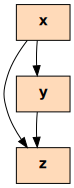

In [146]:
# ignore
_test_data.dependencies().graph()

In the remainder of this section, we define methods to

* track control dependencies (`test()`, `__enter__()`, `__exit__()`)
* track function calls and returns (`call()`, `ret()`)
* track function arguments (`arg()`, `param()`)
* check the validity of our dependencies (`validate()`).

Like our `get()` and `set()` methods above, these work by refining the appropriate methods defined in the `DataTracker` class, building on our `NodeTransformer` transformations.

### Excursion: Control Dependencies

Let us detail control dependencies. As discussed with `DataTracker()`, we invoke `test()` methods for all control conditions, and place the controlled blocks into `with` clauses.

The `test()` method simply sets a `<test>` variable; this also places it in `last_read`.

In [147]:
class DependencyTracker(DependencyTracker):
    def test(self, value):
        """Track a test for condition VALUE"""
        self.set(self.TEST, value)
        return super().test(value)

When entering a `with` block, the set of `last_read` variables holds the `<test>` variable read. We save it in the `control` stack, with the effect of any further variables written now being marked as  controlled by `<test>`.

In [148]:
class DependencyTracker(DependencyTracker):
    def __enter__(self):
        """Track entering an if/while/for block"""
        self.control.append(self.last_read)
        self.clear_read()
        super().__enter__()

When we exit the `with` block, we restore earlier `last_read` values, preparing for `else` blocks.

In [149]:
class DependencyTracker(DependencyTracker):
    def __exit__(self, exc_type, exc_value, traceback):
        """Track exiting an if/while/for block"""
        self.clear_read()
        self.last_read = self.control.pop()
        self.ignore_next_location_change()
        super().__exit__(exc_type, exc_value, traceback)

Here's an example of all these parts in action:

In [150]:
_test_data = DependencyTracker()
x = _test_data.set('x', 1)
y = _test_data.set('y', _test_data.get('x', x))

In [151]:
if _test_data.test(_test_data.get('x', x) >= _test_data.get('y', y)):
    with _test_data:
        z = _test_data.set('z',
                           _test_data.get('x', x) + _test_data.get('y', y))

In [152]:
_test_data.control_dependencies

{('x', ('<module>', 2)): set(),
 ('y', ('<module>', 3)): set(),
 ('<test>', ('<module>', 1)): set(),
 ('z', ('<module>', 4)): {('<test>', ('<module>', 1))}}

The control dependency for `z` is reflected in the dependency graph:

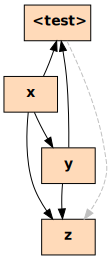

In [153]:
# ignore
_test_data.dependencies().graph()

### End of Excursion

### Excursion: Calls and Returns

To handle complex expressions involving functions, we introduce a _data stack_. Every time we invoke a function `func` (`call()` is invoked), we save the list of current variables read `last_read` on the `data` stack; when we return (`ret()` is invoked), we restore `last_read`. This also ensures that only those variables read while evaluating arguments will flow into the function call.

In [154]:
class DependencyTracker(DependencyTracker):
    def call(self, fun):
        """Track a call of function FUN"""
        super().call(fun)

        if inspect.isgeneratorfunction(fun):
            return self.call_generator(fun)

        # Save context
        if self.log:
            code_name, lineno = self.caller_location()
            print(f"{code_name}:{lineno}: "
                  f"saving read variables {self.last_read}")

        self.data.append(self.last_read)
        self.clear_read()
        self.ignore_next_location_change()

        self.frames.append(self.args)
        self.args = {}

        return fun

In [155]:
class DependencyTracker(DependencyTracker):
    def ret(self, value):
        """Track a return of function FUN"""
        super().ret(value)

        if self.in_generator():
            return self.ret_generator(value)

        # Restore old context and add return value
        ret_name = None
        for var in self.last_read:
            if var.startswith("<"):  # "<return value>"
                ret_name = var

        self.last_read = self.data.pop()
        if ret_name is not None:
            self.last_read.append(ret_name)

        self.ignore_location_change()

        self.args = self.frames.pop()

        if self.log:
            code_name, lineno = self.caller_location()
            print(f"{code_name}:{lineno}: "
                  f"restored read variables {self.last_read}")

        return value

Generator functions (those which `yield` a value) are not "called" in the sense that Python transfers control to them; instead, a "call" to a generator function creates a generator that is evaluated on demand. We mark generator function "calls" by saving `None` on the stacks. When the generator function returns the generator, we wrap the generator such that the arguments are being restored when it is invoked.

In [156]:
import copy

In [157]:
class DependencyTracker(DependencyTracker):
    def in_generator(self):
        """True if we are calling a generator function"""
        return len(self.data) > 0 and self.data[-1] is None

    def call_generator(self, fun):
        """Track a call of a generator function"""
        # Mark the fact that we're in a generator with `None` values
        self.data.append(None)
        self.frames.append(None)
        assert self.in_generator()

        self.clear_read()
        return fun

    def ret_generator(self, generator):
        """Track the return of a generator function"""
        # Pop the two 'None' values pushed earlier
        self.data.pop()
        self.frames.pop()

        if self.log:
            code_name, lineno = self.caller_location()
            print(f"{code_name}:{lineno}: "
                  f"wrapping generator {generator} (args={self.args})")

        # At this point, we already have collected the args.
        # The returned generator depends on all of them.
        for arg in self.args:
            self.last_read += self.args[arg]

        # Wrap the generator such that the args are restored 
        # when it is actually invoked, such that we can map them
        # to parameters.
        saved_args = copy.deepcopy(self.args)

        def wrapper():
            self.args = saved_args
            if self.log:
                code_name, lineno = self.caller_location()
                print(f"{code_name}:{lineno}: "
                  f"calling generator (args={self.args})")

            self.ignore_next_location_change()
            yield from generator

        return wrapper()

We see an example of how function calls and returns work in conjunction with function arguments, discussed in the next section.

### End of Excursion

### Excursion: Function Arguments

Finally, we handle parameters and arguments. The `args` stack holds the current stack of function arguments, holding the `last_read` variable for each argument.

In [158]:
class DependencyTracker(DependencyTracker):
    def arg(self, value, pos=None, kw=None):
        """Track passing an argument VALUE
        (with given position POS 1..n or keyword KW)"""
        if self.log:
            code_name, lineno = self.caller_location()
            print(f"{code_name}:{lineno}: "
                  f"saving args read {self.last_read}")

        if pos:
            self.args[pos] = self.last_read
        if kw:
            self.args[kw] = self.last_read

        self.clear_read()
        return super().arg(value, pos, kw)

When accessing the arguments (with `param()`), we can retrieve this set of read variables for each argument.

In [159]:
class DependencyTracker(DependencyTracker):
    def param(self, name, value, pos=None, vararg="", last=False):
        """Track getting a parameter NAME with value VALUE
        (with given position POS).
        vararg parameters are indicated by '*' (*args) or '**' (**kwargs)"""
        self.clear_read()

        if vararg == '*':
            # We overapproximate by setting `args` to _all_ positional args
            for index in self.args:
                if isinstance(index, int) and index >= pos:
                    self.last_read += self.args[index]
        elif vararg == '**':
            # We overapproximate by setting `kwargs` to _all_ passed keyword args
            for index in self.args:
                if isinstance(index, str):
                    self.last_read += self.args[index]
        elif name in self.args:
            self.last_read = self.args[name]
        elif pos in self.args:
            self.last_read = self.args[pos]

        if self.log:
            code_name, lineno = self.caller_location()
            print(f"{code_name}:{lineno}: "
                  f"restored params read {self.last_read}")

        self.ignore_location_change()
        ret = super().param(name, value, pos)

        if last:
            self.clear_read()
        return ret

Let us illustrate all these on a small example.

In [160]:
def call_test():
    c = 47

    def sq(n):
        return n * n

    def gen(e):
        yield e * c

    def just_x(x, y):
        return x

    a = 42
    b = gen(a)
    d = list(b)[0]

    xs = [1, 2, 3, 4]
    ys = [sq(elem) for elem in xs if elem > 2]

    return just_x(just_x(d, y=b), ys[0])

In [161]:
call_test()

1974

We apply all our transformers on this code:

In [162]:
call_tree = ast.parse(inspect.getsource(call_test))
TrackCallTransformer().visit(call_tree)
TrackSetTransformer().visit(call_tree)
TrackGetTransformer().visit(call_tree)
TrackControlTransformer().visit(call_tree)
TrackReturnTransformer().visit(call_tree)
TrackParamsTransformer().visit(call_tree)
dump_tree(call_tree)

def call_test():
    c = _data.set('c', 47)

    def sq(n):
        _data.param('n', n, pos=1, last=True)
        return _data.set('<sq() return value>', _data.get('n', n) * _data.
            get('n', n))

    def gen(e):
        _data.param('e', e, pos=1, last=True)
        yield _data.set('<gen() yield value>', _data.get('e', e) * _data.
            get('c', c))

    def just_x(x, y):
        _data.param('x', x, pos=1)
        _data.param('y', y, pos=2, last=True)
        return _data.set('<just_x() return value>', _data.get('x', x))
    a = _data.set('a', 42)
    b = _data.set('b', _data.ret(_data.call(_data.get('gen', gen))(_data.
        arg(_data.get('a', a), pos=1))))
    d = _data.set('d', _data.ret(_data.call(list)(_data.arg(_data.get('b',
        b), pos=1)))[0])
    xs = _data.set('xs', [1, 2, 3, 4])
    ys = _data.set('ys', [_data.ret(_data.call(_data.get('sq', sq))(_data.
        arg(_data.get('elem', elem), pos=1))) for elem in _data.set('elem',
        _data.get('xs', x

Again, we capture the dependencies:

In [163]:
class DependencyTrackerTester(DataTrackerTester):
    def make_data_tracker(self):
        return DependencyTracker(log=self.log)

In [164]:
with DependencyTrackerTester(call_tree, call_test, log=False) as deps:
    call_test()

We see how 

* `a` flows into the generator `b` and into the parameter `e` of `gen()`.
* `xs` flows into `elem` which in turn flows into the parameter `n` of `sq()`. Both flow into `ys`.
* `just_x()` returns only its `x` argument.

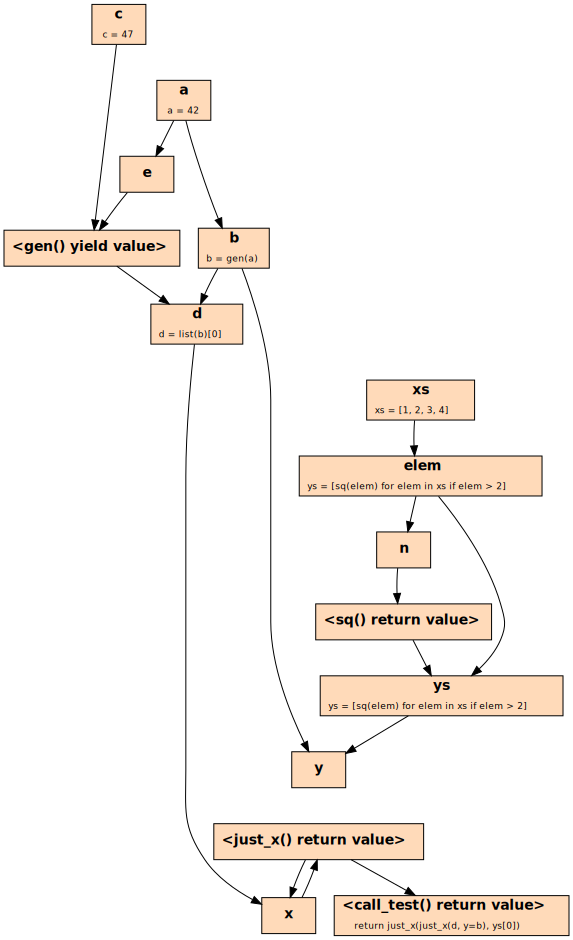

In [165]:
deps.dependencies().graph()

(Note that the Python `inspect` module cannot get the source code of nested functions such as `just_x()`; hence, the variables and return values of `gen()`, `sq()`, and `just_x()` are listed without locations.)

### End of Excursion

### Excursion: Diagnostics

To check the dependencies we obtain, we perform some minimal checks on whether a referenced variable actually also occurs in the source code.

In [166]:
import re
import sys

In [167]:
class Dependencies(Dependencies):
    def validate(self):
        """Perform a simple syntactic validation of dependencies"""
        super().validate()

        for var in self.all_vars():
            source = self.source(var)
            if not source:
                continue

            for dep_var in self.data[var] | self.control[var]:
                dep_name, dep_location = dep_var

                if dep_name == DependencyTracker.TEST:
                    continue  # dependency on <test>

                if dep_name.endswith(' value>'):
                    if source.find('(') < 0:
                        print(f"Warning: {self.format_var(var)} "
                              f"depends on {self.format_var(dep_var)}, "
                              f"but {repr(source)} does not "
                              f"seem to have a call",
                              file=sys.stderr
                             )
                    continue

                if source.startswith('def'):
                    continue   # function call

                rx = re.compile(r'\b' + dep_name + r'\b')
                if rx.search(source) is None:
                    print(f"Warning: {self.format_var(var)} "
                          f"depends on {self.format_var(dep_var)}, "
                          f"but {repr(dep_name)} does not occur "
                          f"in {repr(source)}",
                          file=sys.stderr
                         )

`validate()` is automatically called whenever dependencies are output, so if you see any of its error messages, something may be wrong.

### End of Excursion

At this point, `DependencyTracker` is complete; we have all in place to track even complex dependencies in instrumented code.

## Slicing Code

Let us now put all these pieces together. We have a means to instrument the source code (our various `NodeTransformer` classes) and a means to track dependencies (the `DependencyTracker` class). Now comes the time to put all these things together in a single tool, which we call `Slicer`.

The basic idea of `Slicer` is that you can use it as follows:

```python
with Slicer(func_1, func_2, ...) as slicer:
    func(...)
```

which first _instruments_ the functions given in the constructor (i.e., replaces their definitions with instrumented counterparts), and then runs the code in the body, calling instrumented functions, and allowing the slicer to collect dependencies. When the body returns, the original definition of the instrumented functions is restored.

### An Instrumenter Base Class

The basic functionality of instrumenting a number of functions (and restoring them at the end of the `with` block) comes in a `Instrumenter` base class. It invokes `instrument()` on all items to instrument; this is to be overloaded in subclasses.

In [168]:
class Instrumenter(object):
    def __init__(self, *items_to_instrument, log=False):
        """Create an instrumenter"""
        self.log = log
        self.items_to_instrument = items_to_instrument

    def __enter__(self):
        """Instrument sources"""
        for item in self.items_to_instrument:
            self.instrument(item)
        return self

    def instrument(self, item):
        """Instrument item. To be overloaded in subclasses."""
        if self.log:
            print("Instrumenting", item)

At the end of the `with` block, we restore the given functions.

In [169]:
class Instrumenter(Instrumenter):
    def __exit__(self, exc_type, exc_value, traceback):
        """Restore sources"""
        self.restore()

    def restore(self):
        for item in self.items_to_instrument:
            globals()[item.__name__] = item

By default, an `Instrumenter` simply outputs a log message:

In [170]:
with Instrumenter(middle, log=True) as ins:
    pass

Instrumenting <function middle at 0x7fbc454c4840>


### The Slicer Class

The `Slicer` class comes as a subclass of `Instrumenter`. It sets its own dependency tracker (which can be overwritten by setting the `dependency_tracker` keyword argument).

In [171]:
class Slicer(Instrumenter):
    def __init__(self, *items_to_instrument, 
                 dependency_tracker=None,
                 log=False):
        """Create a slicer.
        ITEMS_TO_INSTRUMENT are Python functions or modules with source code.
        DEPENDENCY_TRACKER is the tracker to be used (default: DependencyTracker).
        LOG=True or LOG > 0 turns on logging"""
        super().__init__(*items_to_instrument, log=log)
        if len(items_to_instrument) == 0:
            raise ValueError("Need one or more items to instrument")

        if dependency_tracker is None:
            dependency_tracker = DependencyTracker(log=(log > 1))
        self.dependency_tracker = dependency_tracker
        self.saved_dependencies = None

The `parse()` method parses a given item, returning its AST.

In [172]:
class Slicer(Slicer):
    def parse(self, item):
        """Parse ITEM, returning its AST"""
        source_lines, lineno = inspect.getsourcelines(item)
        source = "".join(source_lines)

        if self.log >= 2:
            print_content(source, '.py', start_line_number=lineno)
            print()
            print()

        tree = ast.parse(source)
        ast.increment_lineno(tree, lineno - 1)
        return tree

The `transform()` method applies the list of transformers defined earlier in this chapter.

In [173]:
class Slicer(Slicer):
    def transformers(self):
        """List of transformers to apply. To be extended in subclasses."""
        return [
            TrackCallTransformer(),
            TrackSetTransformer(),
            TrackGetTransformer(),
            TrackControlTransformer(),
            TrackReturnTransformer(),
            TrackParamsTransformer()
        ]

    def transform(self, tree):
        """Apply transformers on tree. May be extended in subclasses."""
        # Apply transformers
        for transformer in self.transformers():
            if self.log >= 3:
                print(transformer.__class__.__name__ + ':')

            transformer.visit(tree)
            ast.fix_missing_locations(tree)
            if self.log >= 3:
                print_content(astor.to_source(tree, 
                                              add_line_information=self.log >= 4),
                              '.py')
                print()
                print()

        if 0 < self.log < 3:
            print_content(astor.to_source(tree), '.py')
            print()
            print()

        return tree

The `execute()` method executes the transformed tree (such that we get the new definitions). We also make the dependency tracker available for the code in the `with` block.

In [174]:
class Slicer(Slicer):
    def execute(self, tree):
        """Compile and execute tree. May be extended in subclasses."""
        code = compile(tree, f'<{self.__class__.__name__}>', 'exec')
        exec(code, globals())
        globals()[DATA_TRACKER] = self.dependency_tracker

The `instrument()` method puts all these together, first parsing the item into a tree, then transforming and executing the tree.

In [175]:
class Slicer(Slicer):
    def instrument(self, item):
        """Instrument ITEM, transforming its source code, and re-defining it."""
        super().instrument(item)
        tree = self.parse(item)
        tree = self.transform(tree)
        self.execute(tree)

When we restore the original definition (after the `with` block), we save the dependency tracker again.

In [176]:
class Slicer(Slicer):
    def restore(self):
        """Restore original code."""
        if DATA_TRACKER in globals():
            self.saved_dependencies = globals()[DATA_TRACKER]
            del globals()[DATA_TRACKER]
        super().restore()

Three convenience functions allow us to see the dependencies as (well) dependencies, as code, and as graph. These simply invoke the respective functions on the saved dependencies.

In [177]:
class Slicer(Slicer):
    def dependencies(self):
        """Return collected dependencies."""
        if self.saved_dependencies is None:
            return Dependencies({}, {})
        return self.saved_dependencies.dependencies()

    def code(self, *args, **kwargs):
        """Show code of instrumented items, annotated with dependencies."""
        first = True
        for item in self.items_to_instrument:
            if not first:
                print()
            self.dependencies().code(item, *args, **kwargs)
            first = False

    def graph(self, *args, **kwargs):
        """Show dependency graph."""
        return self.dependencies().graph(*args, **kwargs)

Let us put `Slicer` into action. We track our `middle()` function:

In [178]:
with Slicer(middle) as slicer:
    m = middle(2, 1, 3)
m

1

These are the dependencies in string form (used when printed):

In [179]:
print(slicer.dependencies())

middle():
    <test> (2) <= y (1), z (1)
    <test> (3) <= x (1), y (1); <- <test> (2)
    <test> (5) <= x (1), z (1); <- <test> (3)
    <middle() return value> (6) <= y (1); <- <test> (5)



This is the code form:

In [180]:
slicer.code()

*    1 def middle(x, y, z):
*    2     if y < z:  # <= y (1), z (1)
*    3         if x < y:  # <= x (1), y (1); <- <test> (2)
     4             return y
*    5         elif x < z:  # <= x (1), z (1); <- <test> (3)
*    6             return y  # <= y (1); <- <test> (5)
     7     else:
     8         if x > y:
     9             return y
    10         elif x > z:
    11             return x
    12     return z


And this is the graph form:

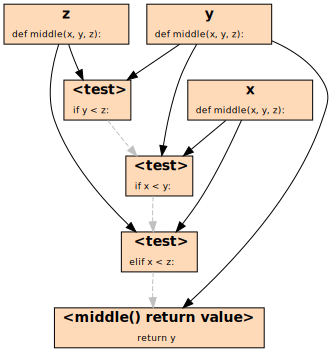

In [181]:
slicer.graph()

You can also access the raw `repr()` form, which allows you to reconstruct dependencies at any time. (This is how we showed off dependencies at the beginning of this chapter, before even introducing the code that computes them.)

In [182]:
slicer.dependencies()

Dependencies({('x', ('middle', 1)): set(), ('y', ('middle', 1)): set(), ('z', ('middle', 1)): set(), ('<test>', ('middle', 2)): {('y', ('middle', 1)), ('z', ('middle', 1))}, ('<test>', ('middle', 3)): {('x', ('middle', 1)), ('y', ('middle', 1))}, ('<test>', ('middle', 5)): {('x', ('middle', 1)), ('z', ('middle', 1))}, ('<middle() return value>', ('middle', 6)): {('y', ('middle', 1))}}, {('x', ('middle', 1)): set(), ('y', ('middle', 1)): set(), ('z', ('middle', 1)): set(), ('<test>', ('middle', 2)): set(), ('<test>', ('middle', 3)): {('<test>', ('middle', 2))}, ('<test>', ('middle', 5)): {('<test>', ('middle', 3))}, ('<middle() return value>', ('middle', 6)): {('<test>', ('middle', 5))}})

### Diagnostics

The `Slicer` constructor accepts a `log` argument (default: False), which can be set to show various intermediate results:

* `log=True` (or `log=1`): Show instrumented source code
* `log=2`: Also log execution
* `log=3`: Also log individual transformer steps
* `log=4`: Also log source line numbers

## More Examples

Let us demonstrate our `Slicer` class on a few more examples.

### Square Root

The `square_root()` function from [the chapter on assertions](Assertions.ipynb) demonstrates a nice interplay between data and control dependencies.

In [183]:
import math

In [184]:
from Assertions import square_root  # minor dependency

Here is the original source code:

In [185]:
print_content(inspect.getsource(square_root), '.py')

def square_root(x):
    assert x >= 0  # precondition

    approx = None
    guess = x / 2
    while approx != guess:
        approx = guess
        guess = (approx + x / approx) / 2

    assert math.isclose(approx * approx, x)
    return approx

Turning on logging shows the instrumented version:

In [186]:
with Slicer(square_root, log=True) as root_slicer:
    y = square_root(2.0)

Instrumenting <function square_root at 0x7fbc45d240d0>
def square_root(x):
    _data.param('x', x, pos=1, last=True)
    assert _data.get('x', x) >= 0
    approx = _data.set('approx', None)
    guess = _data.set('guess', _data.get('x', x) / 2)
    while _data.test(_data.get('approx', approx) != _data.get('guess', guess)):
        with _data:
            approx = _data.set('approx', _data.get('guess', guess))
            guess = _data.set('guess', (_data.get('approx', approx) + _data
                .get('x', x) / _data.get('approx', approx)) / 2)
    assert _data.ret(_data.call(_data.get('math', math).isclose)(_data.arg(
        _data.get('approx', approx) * _data.get('approx', approx), pos=1),
        _data.arg(_data.get('x', x), pos=2)))
    return _data.set('<square_root() return value>', _data.get('approx',
        approx))



The dependency graph shows how `guess` and `approx` flow into each other until they are the same.

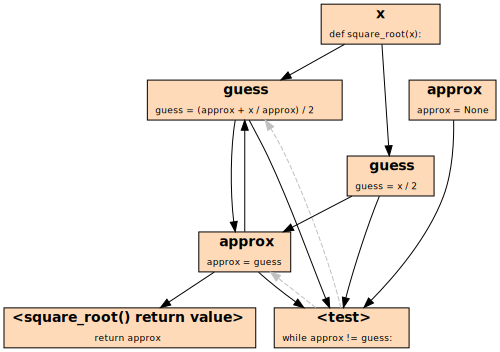

In [187]:
root_slicer.graph()

Again, we can show the code annotated with dependencies:

In [188]:
root_slicer.code()

*   51 def square_root(x):
    52     assert x >= 0  # precondition
    53 
*   54     approx = None
*   55     guess = x / 2  # <= x (51)
*   56     while approx != guess:  # <= approx (54), guess (58), guess (55), approx (57)
*   57         approx = guess  # <= guess (58), guess (55); <- <test> (56)
*   58         guess = (approx + x / approx) / 2  # <= x (51), approx (57); <- <test> (56)
    59 
    60     assert math.isclose(approx * approx, x)
*   61     return approx  # <= approx (57)


The astute reader may find that an `assert p` statements do not control the following code, although it would be equivalent to `if not p: raise Exception`. Why is that?

In [189]:
quiz("Why don't `assert` statements induce control dependencies?",
     [
         "We have no special handling of `assert` statements",
         "We have no special handling of `raise` statements",
         "Assertions are not supposed to act as controlling mechanisms",
         "All of the above",
     ],
     (1 * 1 << 1 * 1 << 1 * 1)
    )

Indeed: we treat assertions as "neutral" in the sense that they do not affect the remainder of the program – if they are turned off, they have no effect; and if they are turned on, the remaining program logic should not depend on them. (Our instrumentation also has no special treatment of `assert`, `raise`, or even `return` statements; the latter two should be handled by our `with` blocks.)

In [190]:
# root_slicer.dependencies()

### Removing HTML Markup

Let us come to our ongoing example, `remove_html_markup()`. This is how its instrumented code looks like:

In [191]:
with Slicer(remove_html_markup) as rhm_slicer:
    s = remove_html_markup("<foo>bar</foo>")

The graph is as discussed in the introduction to this chapter:

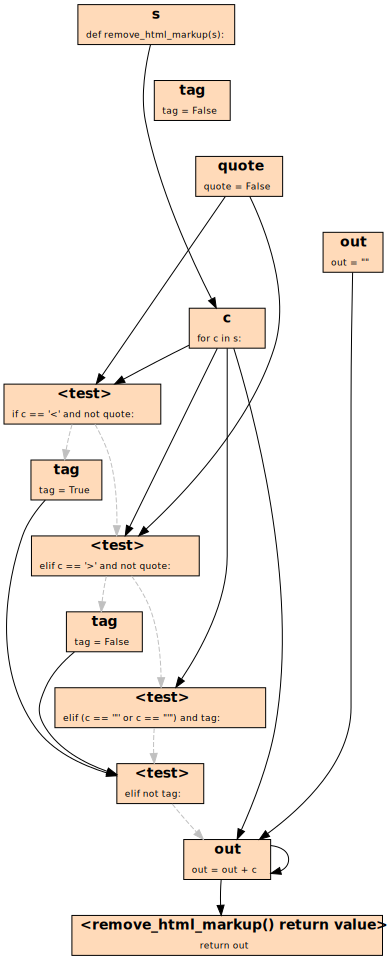

In [192]:
rhm_slicer.graph()

In [193]:
# rhm_slicer.dependencies()

In [194]:
rhm_slicer.code()

*  136 def remove_html_markup(s):
*  137     tag = False
*  138     quote = False
*  139     out = ""
   140 
*  141     for c in s:  # <= s (136)
   142         assert tag or not quote
   143 
*  144         if c == '<' and not quote:  # <= c (141), quote (138)
*  145             tag = True  # <- <test> (144)
*  146         elif c == '>' and not quote:  # <= c (141), quote (138); <- <test> (144)
*  147             tag = False  # <- <test> (146)
*  148         elif (c == '"' or c == "'") and tag:  # <= c (141); <- <test> (146)
   149             quote = not quote
*  150         elif not tag:  # <= tag (145), tag (147); <- <test> (148)
*  151             out = out + c  # <= out (151), c (141), out (139); <- <test> (150)
   152 
*  153     return out  # <= out (151)


We can also compute slices over the dependencies:

In [195]:
_, start_remove_html_markup = inspect.getsourcelines(remove_html_markup)
start_remove_html_markup

136

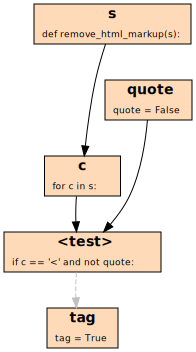

In [196]:
slicing_criterion = ('tag', ('remove_html_markup', 
                             start_remove_html_markup + 9))
tag_deps = rhm_slicer.dependencies().backward_slice(slicing_criterion)
tag_deps.graph()

In [197]:
# tag_deps

### Calls and Augmented Assign

Our last example covers augmented assigns and data flow across function calls. We introduce two simple functions `add_to()` and `mul_with()`:

In [198]:
def add_to(n, m):
    n += m
    return n

In [199]:
def mul_with(x, y):
    x *= y
    return x

And we put these two together in a single call:

In [200]:
def test_math():
    return mul_with(1, add_to(2, 3))

In [201]:
with Slicer(add_to, mul_with, test_math) as math_slicer:
    test_math()

The resulting dependence graph nicely captures the data flow between these calls, notably arguments and parameters:

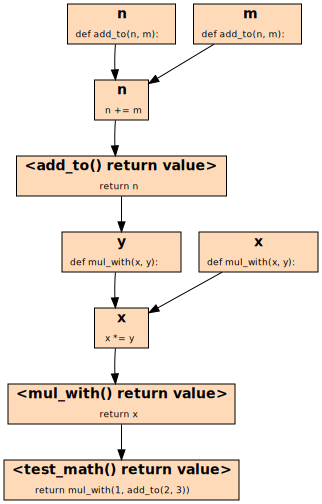

In [202]:
math_slicer.graph()

These are also reflected in the code view:

In [203]:
math_slicer.code()

*    1 def add_to(n, m):
*    2     n += m  # <= m (1), n (1)
*    3     return n  # <= n (2)

*    1 def mul_with(x, y):  # <= <add_to() return value> (add_to:3)
*    2     x *= y  # <= x (1), y (1)
*    3     return x  # <= x (2)

     1 def test_math():
*    2     return mul_with(1, add_to(2, 3))  # <= <mul_with() return value> (mul_with:3)


## Things that do not Work

Our slicer (and especially the underlying dependency tracker) is still a proof of concept. A number of Python features are not or only partially supported, and/or hardly tested:

* __Exceptions__ are not handled. The code assumes that for every `call()`, there is a matching `ret()`; when exceptions break this, dependencies across function calls and arguments may be assigned incorrectly.
* The source code of __nested functions__ cannot be shown or matched; this is a limitation of the Python `inspect` module.
* __Multiple definitions on a single line__  as in `x = y; x = 1` are not handled correctly. Our implementation assumes that there is one statement per line.
* __If-Expressions__ (`y = 1 if x else 0`) do not create control dependencies, as there are no statements to control. Neither do `if` clauses in comprehensions.
* __Asynchronous functions__ (`async`, `await`) are not tested.

In these cases, the instrumentation and the underlying dependency tracker may fail to identify control and/or data flows. The semantics of the code, however, should always stay unchanged.

## Synopsis

This chapter provides a `Slicer` class to automatically determine and visualize dynamic dependencies. When we say that a variable $x$ depends on a variable $y$ (written $x \leftarrow y$), we distinguish two kinds of dependencies:

* **data dependencies**: $x$ obtains its value from a computation involving the value of $y$.
* **control dependencies**: $x$ obtains its value because of a computation involving the value of $y$.

Such dependencies are crucial for debugging, as they allow to determine the origins of individual values (and notably incorrect values).

To determine dynamic dependencies in a function `func` and its callees `func1`, `func2`, etc., use

```python
with Slicer(func, func1, func2) as slicer:
    <Some code involving func()>
```

and then `slicer.graph()` or `slicer.code()` to examine dependencies.

Here is an example. The `demo()` function computes some number from `x`:

In [204]:
def demo(x):
    z = x
    while x <= z <= 64:
        z *= 2
    return z

By using `with Slicer(demo)`, we first instrument `demo()` and then execute it:

In [205]:
with Slicer(demo) as slicer:
    demo(10)

After execution is complete, you can use `slider.graph()` to visualize the dependencies as graph. Data dependencies are shown as black solid edges; control dependencies are shown as grey dashed edges. We see how the parameter `x` flows into `z`, which is returned after some computation that is control dependent on a `<test>` involving `z`.

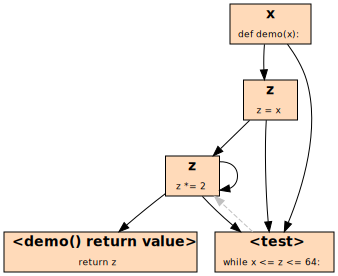

In [206]:
slicer.graph()

An alternate representation is `slicer.code()`, annotating the instrumented source code with (backward) dependencies. Data dependencies are shown with `<=`, control dependencies with `<-`; locations (lines) are shown in parentheses.

In [207]:
slicer.code()

*    1 def demo(x):
*    2     z = x  # <= x (1)
*    3     while x <= z <= 64:  # <= x (1), z (4), z (2)
*    4         z *= 2  # <= z (4), z (2); <- <test> (3)
*    5     return z  # <= z (4)


Dependencies can also be retrieved programmatically. The `dependencies()` method returns a `Dependencies` object encapsulating the dependency graph.

The method `all_vars()` returns all variables in the dependency graph. Each variable is encoded as a pair (_name_, _location_) where _location_ is a pair (_codename_, _lineno_).

In [208]:
slicer.dependencies().all_vars()

{('<demo() return value>', ('demo', 5)),
 ('<test>', ('demo', 3)),
 ('x', ('demo', 1)),
 ('z', ('demo', 2)),
 ('z', ('demo', 4))}

`code()` and `graph()` methods can also be applied on dependencies. The method `backward_slice(var)` returns a backward slice for the given variable. To retrieve where `z` in Line 2 came from, use:

In [209]:
_, start_demo = inspect.getsourcelines(demo)
start_demo

1

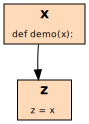

In [210]:
slicer.dependencies().backward_slice(('z', ('demo', start_demo + 1))).graph()

## Lessons Learned

* To track the origin of some incorrect value, follow back its _dependencies_:
    * _Data dependencies_ indicate where the value came from.
    * _Control dependencies_ show why a statement was executed.
* A _slice_ is a subset of the code that could have influenced a specific value. It can be computed by transitively following all dependencies.
* _Instrument code_ to automatically determine and visualize dependencies.

## Next Steps

In the [next chapter](StatisticalDebugger.ipynb), we will explore how to make use of _multiple_ passing and failing executions.

## Background

Slicing as computing a subset of a program by means of data and control dependencies was invented by Mark Weiser \cite{Weiser1981}. In his seminal work "Programmers use Slices when Debugging", \cite{Weiser1982}, Weiser demonstrated how such dependencies are crucial for systematic debugging:

> When debugging unfamiliar programs programmers use program pieces called _slices_ which are sets of statements related by their flow of data. The statements in a slice are not necessarily textually contiguous, but may be scattered through a program.

Weiser's slices (and dependencies) were determined _statically_ from program code. Both Korel and Laski \cite{Korel1988} as well as Agrawal and Horgan \cite{Agrawal1990} introduced _dynamic_ program slicing, building on _dynamic_ dependencies, which would be more specific to a given (failing) run. (The `Slicer` we implement in this chapter is a dynamic slicer.) Tip \cite{tip1995} gives a survey on program slicing techniques. Chen et al. \cite{Chen2014} describe and evaluate the first dynamic slicer for Python programs (which is independent from our implementation).

One examplary application of program slices is [the Whyline](https://github.com/amyjko/whyline) by Ko and Myers \cite{Ko2004}. The Whyline a debugging interface for asking questions about program behavior. It allows to interactively query where a particular variable came from (a data dependency) and why or why not specific things took place (control dependencies).

In \cite{Soremekun2021}, Soremekun et al. evaluated the performance of slicing as a fault localization mechanism and found that following dependencies was one of the most successful strategies to determine fault locations. Notably, if programmers first examine at most the top five most suspicious locations from [statistical debugging](StatisticalDebugger.ipynb), and then switch to dynamic slices, on average, they will need to examine only 15% (12 lines) of the code. 

## Exercises


### Exercise 1: Forward Slicing

Extend `Dependencies` with a variant of `backward_slice()` named `forward_slice()` that, instead of computing the dependencies that go _into_ a a location, computes the dependencies that go _out_ of a location.

### Exercise 2: Code with Forward Dependencies

Create a variant of `Dependencies.code()` that, for each statement `s`, instead of showing a "passive" view (which variables and locations influenced `s`?), shows an "active" view (which variables and locations were influenced by `s`?). For `middle()`, for instance, the first line should show which lines are influenced by `x`, `y`, and `z`, respectively. Use `->` for control flows and `=>` for data flows.

### Exercise 3: Determine Instrumented Functions Dynamically

When initializing `Slicer()`, one has to provide the set of functions to be instrumented. This is because the instrumentation has to take place _before_ the code in the `with` block is executed.

Create a subclass of `Slicer`, called `AutoSlicer` that determines these functions automatically. It would be used as

```python
with AutoSlicer() as slicer:
    func(...)
```

and proceeds in two steps:

1. Run the code in the `with` block, using the `Tracer` class from [the chapter on tracing](Tracer.ipynb). Collect the first call to `func()` and its arguments, as well as the names of all subsequent called functions.
2. Repeat the first call to `func()`, now with all called functions being instrumented as in `Slicer`.